In [1]:
#!pip install -I rpy2==3.4.2

In [25]:
import rpy2
print(rpy2.__version__)

3.4.5


# Code basis

2023-04-11 01:13:44.411875: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-11 01:13:48.475610: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-11 01:14:04.849287: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


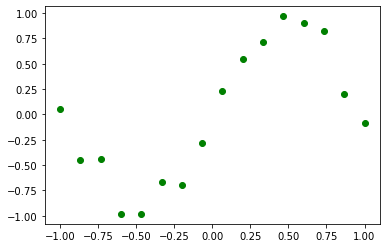

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# %%
# import packages, set path and create tf session

import numpy as np
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, concatenate, Add
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras import regularizers, Model
from tensorflow.keras import optimizers
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import tensorflow
import rpy2.robjects as robjects

project_path = ""

#sess = tensorflow.InteractiveSession()
#sess.run(tensorflow.global_variables_initializer())


# # =============================================================
# # REPRODUCABILITY
# # ------------------------------------------------------------------------------------------------------
# import random
# tensorflow.compat.v1.keras.backend.clear_session()

# # 1. Set `python` built-in pseudo-random generator at a fixed value
# random.seed(1)

# # 2. Set `numpy` pseudo-random generator at a fixed value
# np.random.seed(2)

# # 3. Set the `tensorflow` pseudo-random generator at a fixed value
# tensorflow.random.set_seed(3)

# # 4. Configure a new global `tensorflow` session
# session_conf = tensorflow.compat.v1.ConfigProto(
#     intra_op_parallelism_threads=1, inter_op_parallelism_threads=1
# )
# sess = tensorflow.compat.v1.Session(
#     graph=tensorflow.compat.v1.get_default_graph(), config=session_conf
# )
# tensorflow.compat.v1.keras.backend.set_session(sess)
# # =============================================================



# %%
# define functions
def add_if_not_None(variable_x,add_to_x):
  if variable_x is not None:
    return variable_x + add_to_x
  else:
    return None


def createModelOld(n=100, s=0.05, l2reg=0, seed=None, use_final_bias=True):
    # creates an RSN with n hidden nodes with first-layer parameters
    # sampled from Unif[-s, s] and terminal-layer parameters initialized
    # to zero. Ridge regularization on all parameters is controlled by l2reg.

    model = Sequential()
    model.add(Dense(n,
                    activation='relu',
                    input_dim=d,
                    trainable=False,
                    kernel_initializer=RandomUniform(minval=-s,
                                                     maxval=s,
                                                     seed=seed),
                    bias_initializer=RandomUniform(minval=-s,
                                                   maxval=s,
                                                   seed=seed),
                    kernel_regularizer=regularizers.l2(l2reg),
                    bias_regularizer=regularizers.l2(l2reg),
                    name="myHiddenLayer"))
    model.add(Dense(1,
                    activation='linear',
                    kernel_initializer=keras.initializers.Zeros(),
                    bias_initializer=keras.initializers.Zeros(),
                    kernel_regularizer=regularizers.l2(l2reg),
                    bias_regularizer=regularizers.l2(l2reg),
                    name="myOutputLayer",
                    use_bias=use_final_bias))
 
    return model

def createModel(n=100, s=0.05, l2reg=0, seed=None, use_final_bias=True, linear_skip=False, din=1, l2reg_factor_affine_weights=1):
    # creates an RSN with n hidden nodes with first-layer parameters
    # sampled from Unif[-s, s] and terminal-layer parameters initialized
    # to zero. Ridge regularization on all parameters is controlled by l2reg.
    if not(use_final_bias) and linear_skip:
      print("Are you sure you want the linear skip connection but no intercept? This is a very unusual combnation.")

    l_in = Input(shape=(din, ), name='input')
    l=Dense(n,
            activation='relu',
            input_dim=din,
            trainable=False,
            kernel_initializer=RandomUniform(minval=-s,
                                              maxval=s,
                                              seed=seed),
            bias_initializer=RandomUniform(minval=-s,
                                            maxval=s,
                                            seed=add_if_not_None(seed,1)),
            kernel_regularizer=regularizers.l2(l2reg),
            bias_regularizer=regularizers.l2(l2reg),
            name="myHiddenLayer")(l_in)
    l=Dense(1,
            activation='linear',
            kernel_initializer=keras.initializers.Zeros(),
            bias_initializer=keras.initializers.Zeros(),
            kernel_regularizer=regularizers.l2(l2reg),
            bias_regularizer=regularizers.l2(l2reg_factor_affine_weights*l2reg),
            name="myOutputLayer",
            use_bias=use_final_bias)(l)
    if linear_skip:
      l_linearSkip = Dense(1,
                          activation='linear',
                          input_dim=din,
                          trainable=True,
                          kernel_initializer=keras.initializers.Zeros(),
                          use_bias=False,
                          kernel_regularizer=regularizers.l2(l2reg_factor_affine_weights*l2reg),
                          name="myLinearSkipLayer")(l_in)
      l=Add()([l,l_linearSkip])
 
    return Model(inputs=[l_in], outputs=l)


def createModelRandomIni(n=100, s=0.05, l2reg=0,
                         seed=None, sSecondLayerRand=None, use_final_bias=True):
    # creates an RSN with n hidden nodes with first-layer parameters
    # sampled from Unif[-s, s] and terminal-layer parameters initialized
    # to samples from Unif[-sSecondLayerRand, sSecondLayerRand].
    # Ridge regularization on all parameters is controlled by l2reg.

    # if no value for sSecondLayerRand is provided, choose Unif[-s, s] 
    # initialization for terminal-layer parameters as well
    if not sSecondLayerRand:
        sSecondLayerRand = s

    model = Sequential()
    model.add(Dense(n,
                    activation='relu',
                    input_dim=d,
                    trainable=False,
                    kernel_initializer=RandomUniform(minval=-s,
                                                     maxval=s,
                                                     seed=seed),
                    bias_initializer=RandomUniform(minval=-s,
                                                   maxval=s,
                                                   seed=add_if_not_None(seed,1)),
                    kernel_regularizer=regularizers.l2(l2reg),
                    bias_regularizer=regularizers.l2(l2reg),
                    name="myHiddenLayer"))
    model.add(Dense(d,
                    activation='linear',
                    kernel_initializer=RandomUniform(minval=-sSecondLayerRand,
                                                     maxval=sSecondLayerRand,
                                                     seed=add_if_not_None(seed,2)),
                    bias_initializer=RandomUniform(minval=-sSecondLayerRand,
                                                   maxval=sSecondLayerRand,
                                                   seed=add_if_not_None(seed,3)),
                    kernel_regularizer=regularizers.l2(l2reg),
                    bias_regularizer=regularizers.l2(l2reg),
                    name="myOutputLayer",
                    use_bias=use_final_bias)) 
    return model


def splineFit(x_train, y_train, lamb):
    # extract R function for cubic smoothing spline and fit it to data w.r.t.
    # the penalty parameter lamb
    # returns the fitted spline

    r_x = robjects.FloatVector(x_train)
    r_y = robjects.FloatVector(y_train)

    r_smooth_spline = robjects.r['smooth.spline'] #extract R function
    kwargs = {"x": r_x, "y": r_y, "lambda": lamb}

    return r_smooth_spline(**kwargs)


def splinePredict(spline, x):
    # evaluate the fitted cubic smoothing spline 'spline' at the data x
    # returns: function evaluations as np.array

    pred = robjects.r['predict'](spline, robjects.FloatVector(x)).rx2('y')
    return np.array(pred)

# %%
# set parameters and create data

np.random.seed(seed=3+2)  # set seed

d = 1  # output dimension
n_samples = 16  # number of samples

# RSN parameter
s = 0.05  # range of random initialization
n = 1024  # number of hidden nodes

weight_name="no_name_given"


# training data
x_min = -1
x_max = 1
x_train = np.array(np.linspace(x_min, x_max, n_samples)).reshape(n_samples, d)
x_train = np.sort(x_train, 0)

# xrange for plots
resolution = 1920
x_smooth = np.array(np.linspace(x_min, x_max, resolution)).reshape(resolution, 1)

y_min = -500.6
y_max = 500.6

# training output #HERE YOU CAN CHANGE THE y-DATA BY REPLACING np.sin
y_train = (np.random.normal(scale=1/8,
                            size=n_samples)+np.sin(np.pi*x_train[:, 0]))

# validation data
x_val = ((np.random.rand(256, d)-0.5)*2.0).reshape(256, d)
y_val = np.sin(np.pi*x_val[:, 0])

# plot training (and validation data)
plt.plot(x_train, y_train,'go')
#plt.plot(x_val, y_val,'k.')
plt.show()

# %%
# set up RSN and compile

def train_model(model,lr=0.1,
                x_train=x_train,
                y_train=y_train,
                batch_size=min(n_samples, 512),
                epoch_nr=1,
                verbose=0,
                validation_data=(x_val, y_val),
                shuffle=True,
                weight_name=weight_name):
  model.compile(optimizer=optimizers.SGD(learning_rate=lr),
                loss='MSE',
                metrics=['MSE'])

  # (plot untrained network)
  #plt.plot(x_smooth,model.predict(x_smooth))
  #plt.plot(x_train, y_train, 'go')

  # %%
  # train RSN 
  history = model.fit(x_train,
                      y_train,
                      batch_size=batch_size,
                      epochs=epoch_nr,
                      verbose=verbose,
                      validation_data=validation_data,
                      shuffle=shuffle)
  # save weights in cwd
  model.save_weights('RSN'+weight_name)
  #w = model.get_weights() #can improof speed

  # (visualize training & validation loss)
  plt.plot(history.history['loss'])
  plt.yscale('log')
  plt.ylim(bottom=np.min(history.history['loss'])*0.99995,top=min(np.max(history.history['loss']),max(history.history['loss'][0],history.history['loss'][-1])*1.001))
  plt.show()
  #plt.plot(history.history['val_loss'])
  return model


def train_modelRidge(modelRidge,lr=0.1,
                x_train=x_train,
                y_train=y_train,
                batch_size=min(n_samples, 512),
                epoch_nr=1,
                verbose=0,
                validation_data=(x_val, y_val),
                shuffle=True,
                weight_name=weight_name,
                new_version=True):
  if not(new_version):
    modelRidge.compile(optimizer=optimizers.Adam(learning_rate=lr*2),
                loss='MSE',
                metrics=['MSE'])
    # %%
    # train ridge regularized RSN
    historyRidge = modelRidge.fit(x_train,
                                  y_train,
                                  batch_size=batch_size,
                                  epochs=int(max(128,epoch_nr/4)), #2**15
                                  verbose=verbose,
                                  validation_data=validation_data,
                                  shuffle=shuffle)
    plt.plot(historyRidge.history['loss'])
    plt.yscale('log')
    plt.ylim(bottom=np.min(historyRidge.history['loss'])*0.99995,top=min(np.max(historyRidge.history['loss']),max(historyRidge.history['loss'][0],historyRidge.history['loss'][-1])*1.001))
    plt.show()
    print(historyRidge.history['loss'][-1])

    modelRidge.compile(optimizer=optimizers.Adam(learning_rate=lr),
                loss='MSE',
                metrics=['MSE'])
    # %%
    # train ridge regularized RSN
    historyRidge = modelRidge.fit(x_train,
                                  y_train,
                                  batch_size=batch_size,
                                  epochs=int(max(256,epoch_nr/2)), #2**15
                                  verbose=verbose,
                                  validation_data=validation_data,
                                  shuffle=shuffle)

    plt.plot(historyRidge.history['loss'])
    plt.yscale('log')
    plt.ylim(bottom=np.min(historyRidge.history['loss'])*0.99995,top=min(np.max(historyRidge.history['loss']),max(historyRidge.history['loss'][0],historyRidge.history['loss'][-1])*1.001))
    plt.show()
    print(historyRidge.history['loss'][-1])

    # modelRidge.compile(optimizer=optimizers.Adam(learning_rate=lr/2),
    #              loss='MSE',
    #              metrics=['MSE'])
    # # %%
    # # train ridge regularized RSN
    # historyRidge = modelRidge.fit(x_train,
    #                               y_train,
    #                               batch_size=min(n_samples, 512),
    #                               epochs=int(epoch_nr), #2**15
    #                               verbose=0,
    #                               validation_data=(x_train, y_train),
    #                               shuffle=True)
    #
    # plt.plot(historyRidge.history['loss'])
    # plt.yscale('log')
    # plt.ylim(bottom=np.min(historyRidge.history['loss'])*0.99995,top=min(np.max(historyRidge.history['loss']),max(historyRidge.history['loss'][0],historyRidge.history['loss'][-1])*1.001))
    # plt.show()
    # print(historyRidge.history['loss'][-1])

    modelRidge.compile(optimizer=optimizers.Adam(learning_rate=lr/32),
                loss='MSE',
                metrics=['MSE'])
    # %%
    # train ridge regularized RSN
    historyRidge = modelRidge.fit(x_train,
                                  y_train,
                                  batch_size=batch_size,
                                  epochs=int(max(128,epoch_nr/4)), #2**15
                                  verbose=verbose,
                                  validation_data=validation_data,
                                  shuffle=shuffle)

    plt.plot(historyRidge.history['loss'])
    plt.yscale('log')
    plt.ylim(bottom=np.min(historyRidge.history['loss'])*0.99995,top=min(np.max(historyRidge.history['loss']),max(historyRidge.history['loss'][0],historyRidge.history['loss'][-1])*1.001))
    plt.show()
    print(historyRidge.history['loss'][-1])

  modelRidge.compile(optimizer=optimizers.SGD(learning_rate=lr/2,momentum=0.5),
              loss='MSE',
              metrics=['MSE'])

  # %%
  # train ridge regularized RSN
  historyRidge = modelRidge.fit(x_train,
                                y_train,
                                batch_size=batch_size,
                                epochs=int(min(1024,max(128,epoch_nr/4))), #2**15
                                verbose=verbose,
                                validation_data=validation_data,
                                shuffle=shuffle)

  plt.plot(historyRidge.history['loss'])
  #plt.yscale('log')
  #plt.ylim(bottom=np.min(historyRidge.history['loss'])*0.99995,top=min(np.max(historyRidge.history['loss']),max(historyRidge.history['loss'][0],historyRidge.history['loss'][-1])*1.001))
  plt.show()
  print("historyRidge.history['loss'][-1]:", historyRidge.history['loss'][-1])

  # save weights in cwd
  modelRidge.save_weights('RidgeRSN'+weight_name)
  return modelRidge

def ridgeRegLastLayer(modelRidge, x_train, y_train, l2reg, tol=0.000001, verbose=1, l2reg_factor_affine_weights=1):
  layer_names=[layer.name for layer in modelRidge.layers]
  n=modelRidge.get_layer("myHiddenLayer").units
  if l2reg_factor_affine_weights<2**(-40):
    print("l2reg_factor_affine_weights is streated as 2**(-40) for numerical stability. YOu should consider taking a larger valuefor more numerical stability.")
  rescale_affine_weights=1/np.sqrt(max(2**(-40),l2reg_factor_affine_weights))
  intermediate_output = tensorflow.keras.Model(modelRidge.input, 
                                      modelRidge.get_layer('myHiddenLayer').output)
  X_matrix=intermediate_output(x_train).numpy()
  if verbose:
    print(X_matrix.shape)
    print("x_train:")
    print(x_train.shape)
    print("rescale_affine_weights: ",rescale_affine_weights)
  additional_dimensions=0
  if "myLinearSkipLayer" in layer_names:
    X_matrix=np.concatenate((X_matrix,rescale_affine_weights*x_train),axis=1)
    additional_dimensions+=1
  if modelRidge.get_layer(name="myOutputLayer").use_bias:
    X_matrix=np.concatenate((X_matrix,rescale_affine_weights*np.ones((n_samples,1))),axis=1)
    additional_dimensions+=1
  from sklearn.linear_model import Ridge
  clf = Ridge(alpha=l2reg*n_samples,fit_intercept=False, tol=tol)
  clf.fit(X_matrix, y_train)
  # import copy
  # modelRidge2=copy.deepcopy(modelRidge)
  if modelRidge.get_layer(name="myOutputLayer").use_bias:
    #print(modelRidge.layers[1].name)
    modelRidge.get_layer(name="myOutputLayer").set_weights([clf.coef_[:n].reshape(-1,1),rescale_affine_weights*clf.coef_[-1].reshape(1,)])
  else:
    modelRidge.get_layer(name="myOutputLayer").set_weights([clf.coef_[:n].reshape(-1,1)])
  if "myLinearSkipLayer" in layer_names:
    modelRidge.get_layer(name="myLinearSkipLayer").set_weights([rescale_affine_weights*clf.coef_[n:(n+1)].reshape(-1,1)])
  print("Ridge regression claculated successfull")
  return modelRidge

def train_both_models(lr=0.1,
                x_train=x_train,
                y_train=y_train,
                batch_size=min(n_samples, 512),
                epoch_nr=1,
                verbose=0,
                validation_data=(x_val, y_val),
                shuffle=True,
                weight_name=weight_name,
                n=100, s=0.05, seed=None, use_final_bias=True, linear_skip=False, din=1, l2reg_factor_affine_weights=1
                ):
  model = createModel(n=n, l2reg=0, seed=seed, use_final_bias=use_final_bias, linear_skip=linear_skip,din=din, l2reg_factor_affine_weights=l2reg_factor_affine_weights)
  tr_time = epoch_nr*lr  # training time  (tr_time*n_samples = T_paper)
  train_model(model,lr=lr,x_train=x_train,
                  y_train=y_train,
                  batch_size=batch_size,
                  epoch_nr=epoch_nr,
                  verbose=verbose,
                  validation_data=validation_data,
                  shuffle=shuffle,
                  weight_name=weight_name)

  # %%
  # set up ridge regularized RSN using eq. (6) in the paper for lambda_tilda

  sSVD = n_samples/(2*tr_time) #(singular value of XTX) = (singular value of X)^2
  lambda_tilda = sSVD/(np.exp(2*sSVD*tr_time/n_samples)-1)/n_samples
  if y_train.size != n_samples:
    print("Warning: y_train.size != n_samples")
    print("y_train.size: ", y_train.size )
    print("n_samples: ", n_samples )
  print("tr_time:",tr_time,", tr_time_paper:",tr_time/n_samples)
  print("lambda_tilde:",lambda_tilda,", lambda_tilde_paper:",lambda_tilda*n_samples,", lambda_tilde equivalent formula:",1/(2*(np.exp(1)-1)*tr_time),", lambda_tilde_paper equivalent formula:",1/(2*(np.exp(1)-1)*(tr_time/n_samples)))
  #lambda_tilda = 1/tr_time #Achtung Falsch!!!

  #modelRidge = createModel(n=n, l2reg=lambda_tilda, use_final_bias=model.layers[1].use_bias) 
  modelRidge = createModel(n=n, l2reg=lambda_tilda, seed=seed, use_final_bias=use_final_bias, linear_skip=linear_skip,din=din, l2reg_factor_affine_weights=l2reg_factor_affine_weights)

  #modelRidge.set_weights(w) #can improof speed
  modelRidge.set_weights(model.get_weights())

  modelRidge=ridgeRegLastLayer(modelRidge, x_train, y_train, l2reg=lambda_tilda, tol=0.000000000000001, l2reg_factor_affine_weights=l2reg_factor_affine_weights)  

  train_modelRidge(modelRidge,lr=lr,x_train=x_train,
                  y_train=y_train,
                  batch_size=batch_size,
                  epoch_nr=epoch_nr,
                  verbose=verbose,
                  validation_data=validation_data,
                  shuffle=shuffle,
                  weight_name=weight_name)
  
  return model,modelRidge,lambda_tilda

# (visualize training loss)
#plt.plot(historyRidge.history['loss'])



## Plot functions

In [2]:
def add_plot_f(model, sign='b', x_min=-1, x_max=1, zoom=[None,None,None,None],file_name="PlusMinus", label_plus=' ',label_minus=' ',color=(1, 5/8, 0.0),add_to_plot=True):
  layer_names=[layer.name for layer in model.layers]
  W1 = model.get_weights()[0]
  b1 = model.get_weights()[1]
  W2 = model.get_weights()[2]
  if model.get_layer(name="myOutputLayer").use_bias:
    b2 = model.get_weights()[3]
    if not b2==model.get_layer(name="myOutputLayer").get_weights()[1]:
      print('b2:')
      print(b2)
      print('model.get_layer(name="myOutputLayer").get_weights()[1]:')
      print(model.get_layer(name="myOutputLayer").get_weights()[1])
      raise Exception("b2 might be calculate incorrectly.")
  else:
    b2=0
  if "myLinearSkipLayer" in layer_names:
    a=model.get_layer(name="myLinearSkipLayer").get_weights()[0][0]
  else:
    a=0
  X1 = np.array(np.linspace(x_min, x_max, 1920)).reshape(1920, 1)

  if sign == '+' or sign == 'b':
    W1a = np.array([[w if w >= 0 else 0 for _,w in enumerate(W1[0])]])
    b1a = np.array([b if W1[0][i] >= 0 else 0 for i,b in enumerate(b1)])
  if sign == '-' or sign == 'b':
    W1b = np.array([[w if w <= 0 else 0 for _,w in enumerate(W1[0])]])
    b1b = np.array([b if W1[0][i] <= 0 else 0 for i,b in enumerate(b1)])
  if sign not in ['+', '-', 'b']:
    print("sign not recognized! Choose among '+', '-', 'b'.")
    return
  
  try:
    L1 = np.dot(X1, W1a) + b1a # first layer
    X2 = np.maximum(L1, 0)   # relu activation function
    L2 = np.dot(X2, W2)# + b2 # second layer (prediction)
    plt.plot(X1, L2, linestyle='dotted', label=label_plus, color=color)
  except NameError:
    pass
  
  try:
    L1 = np.dot(X1, W1b) + b1b # first layer
    X2 = np.maximum(L1, 0)   # relu activation function
    L2 = np.dot(X2, W2)# + b2 # second layer (prediction)
    plt.plot(X1, L2, linestyle='dashed', label=label_minus,color=color)
  except NameError:
    pass
  
  if model.get_layer(name="myOutputLayer").use_bias and "myLinearSkipLayer" in layer_names:
    plt.plot(X1, a*X1+b2, label='ax+c', linestyle='dashdot', color=color)
  elif model.get_layer(name="myOutputLayer").use_bias:
    plt.hlines(b2, xmin=x_min,xmax=x_max, label='c')
  elif "myLinearSkipLayer" in layer_names:
    plt.plot(X1, a*X1, label='ax')

  if not(add_to_plot):
    plt.legend(loc='upper center',frameon=False)
    plt.savefig(file_name+'.svg', format='svg',transparent=True)
    plt.savefig(file_name+'.pdf', format='pdf',transparent=True)
    plt.show()

#plot_f(model,'b', x_min=-3,x_max=3)
# file_name="Constant1PlusMinus"
# add_plot_f(modelRidge,'b', x_min=-3,x_max=3, file_name="Constant1PlusMinus")
# plt.legend(loc='upper center',frameon=False)
# plt.savefig(file_name+'.svg', format='svg',transparent=True)
# plt.savefig(file_name+'.pdf', format='pdf',transparent=True)
# plt.show()

In [3]:
def plot_f_advanced(model, modelRidge, radPlot = 1, x_min=None, x_max=None, y_min=None, y_max=None, legend_loc=None, frameon=False,
                    add_splitting_T=False, add_splitting_ridge=True, file_name="differenceAdaptedSplineVsWeightedSpline",
                    label_T='time-T RSN', label_ridge='ridge RSN', label_spline='spline', label_plus_T='time-T RSN+',label_minus_T='time-T RSN-', label_plus_ridge='ridge RSN+',label_minus_ridge='ridge RSN-',
                    sign='b', add_to_plot=False, version_without_labels=True, legend_alpha=1, framealpha=0.8, LegendBoxEdgecolor='0.8'):
  dict_vars=locals()
  if version_without_labels:
    # for k in dict_vars.keys():
      # if k[0:5]=='label':
      #   print(dict_vars[k])
      #   dict_vars[k]=' '*(2*len(dict_vars[k]))#'                      '#' '*len(dict_vars[k])
      #   print(dict_vars[k])
    dict_vars['legend_alpha']=0.0
    dict_vars['version_without_labels']=False
    dict_vars['file_name']=file_name+'NoLabel'
    print(dict_vars)
    plot_f_advanced(**dict_vars)

  # %%
  # fit spline regression with g(0) and regularizing parameter lambda (lamb)
  # as in the paper including an adjustment for the scaling of lamb
  # (see https://stats.stackexchange.com/a/430482/261315)
  g_Zero = s**2/8/2 
  print('g(0)=', g_Zero)
  lamb = float((n_samples*lambda_tilda/(2*g_Zero)/n)/(max(x_train)-min(x_train))**3)
  lambda_tilda_paper=n_samples*lambda_tilda
  lambda_paper=lambda_tilda_paper/(2*g_Zero*n)
  print("lambda_paper:", lambda_paper)

  spline = splineFit(x_train, y_train, lamb)


  # %%
  # visualize result
  if x_min is None or x_max is None:
    x_min=-radPlot
    x_max=radPlot
  
  xPlot = np.linspace(x_min, x_max, 1920)
  ySpline = splinePredict(spline, xPlot)
  yminPlot = min(np.min(model.predict(xPlot)),
                np.min(modelRidge.predict(xPlot)))-0.05
  ymaxPlot = max(np.max(model.predict(xPlot)),
                np.max(modelRidge.predict(xPlot)))+0.05
    
  plt.plot(x_train, y_train, 'ko', markersize=8)
  #print(xPlot)
  #print(model.predict(xPlot))
  plt.plot(xPlot, model.predict(xPlot), 'r-', linewidth=3, label=label_T)
  plt.plot(xPlot, modelRidge.predict(xPlot), '-', linewidth=2,
          color=(1, 5/8, 0.0), label=label_ridge)
  plt.plot(xPlot, ySpline, 'b-', linewidth=1.5, label=label_spline)

  if add_splitting_T:
    add_plot_f(model=model, sign=sign, x_min=x_min, x_max=x_max, label_plus=label_plus_T,label_minus=label_minus_T,color="r",add_to_plot=True)
  if add_splitting_ridge:
    add_plot_f(model=modelRidge, sign=sign, x_min=x_min, x_max=x_max, label_plus=label_plus_ridge,label_minus=label_minus_ridge,color=(1, 5/8, 0.0),add_to_plot=True)

  plt.ylim(y_min, y_max)
  plt.xlim(x_min, x_max)
  
  legend=plt.legend(loc=legend_loc, frameon=frameon, framealpha=framealpha, edgecolor=LegendBoxEdgecolor)
  plt.setp(legend.get_texts(), alpha=legend_alpha)
  plt.savefig(file_name+'.svg', format='svg',transparent=True)
  plt.savefig(file_name+'.pdf', format='pdf',transparent=True)
  plt.show()

#plot_f_advanced(model, modelRidge, radPlot=2, add_splitting_T=True)

# Experiments

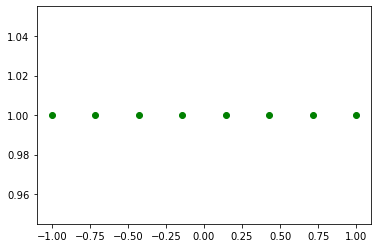

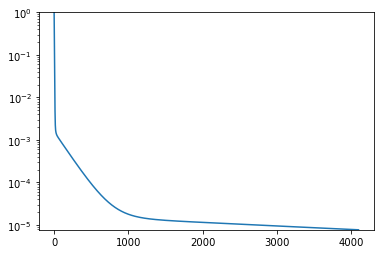

tr_time: 1024.0 , tr_time_paper: 128.0
lambda_tilde: 0.0002841683139010383 , lambda_tilde_paper: 0.0022733465112083065 , lambda_tilde equivalent formula: 0.0002841683139010383 , lambda_tilde_paper equivalent formula: 0.0022733465112083065
(8, 1024)
x_train:
(8, 1)
rescale_affine_weights:  1.0
Ridge regression claculated successfull


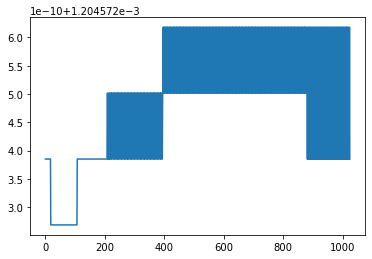

historyRidge.history['loss'][-1]: 0.0012045723851770163


In [23]:
tensorflow.random.set_seed(1)
d = 1  # output dimension
n_samples = 8  # number of samples
n_val= 2

# RSN parameter
s = 0.05  # range of random initialization
n = 1024  # number of hidden nodes

# training parameter
epoch_nr = 2**12#2**11#2**(12)  # number of epochs
lr = 2**(-2)  # learning rate
tr_time = epoch_nr*lr  # training time  (tr_time*n_samples = T_paper)
weight_name = "GrownUp2"+str(epoch_nr)+'_logT'+str(int(math.log(tr_time, 2)))+'.h5'


# training data
x_min = -1
x_max = 1
x_train = np.array(np.linspace(x_min, x_max, n_samples)).reshape(n_samples, d)
x_train = np.sort(x_train, 0)

# xrange for plots
resolution = 1920
x_smooth = np.array(np.linspace(x_min, x_max, resolution)).reshape(resolution, 1)

y_min = -500.6
y_max = 500.6

# training output #HERE YOU CAN CHANGE THE y-DATA BY REPLACING np.sin
y_train = (np.random.normal(scale=0,
                            size=n_samples)+1)

# validation data
x_val = ((np.random.rand(n_val, d)-0.5)*2.0).reshape(n_val, d)
y_val = np.sin(np.pi*x_val[:, 0])*0+1

# plot training (and validation data)
plt.plot(x_train, y_train,'go')
#plt.plot(x_val, y_val,'k.')
plt.show()

(model,modelRidge,lambda_tilda) = train_both_models(lr=lr,
                x_train=x_train,
                y_train=y_train,
                batch_size=min(n_samples, 512),
                epoch_nr=epoch_nr,
                verbose=0,
                validation_data=(x_val, y_val),
                shuffle=True,
                weight_name=weight_name,
                n=n,
                s=s, seed=1, use_final_bias=False, linear_skip=False, din=1, l2reg_factor_affine_weights=1)

#model = createModel(n=n, l2reg=0)

# (model,modelRidge,lambda_tilda) = train_both_models(model,
#                 lr=lr,
#                 x_train=x_train,
#                 y_train=y_train,
#                 batch_size=min(n_samples, 512),
#                 epoch_nr=epoch_nr,
#                 verbose=0,
#                 validation_data=(x_val, y_val),
#                 shuffle=True,
#                 weight_name=weight_name)

{'model': <keras.engine.functional.Functional object at 0x7faf486215a0>, 'modelRidge': <keras.engine.functional.Functional object at 0x7faf481613f0>, 'radPlot': 3, 'x_min': None, 'x_max': None, 'y_min': -1.4, 'y_max': 1.4, 'legend_loc': None, 'frameon': False, 'add_splitting_T': False, 'add_splitting_ridge': True, 'file_name': 'differenceAdaptedSplineVsWeightedSplineNoLabel', 'label_T': 'time-T RSN', 'label_ridge': 'ridge RSN', 'label_spline': 'spline', 'label_plus_T': 'time-T RSN+', 'label_minus_T': 'time-T RSN-', 'label_plus_ridge': 'ridge RSN+', 'label_minus_ridge': 'ridge RSN-', 'sign': 'b', 'add_to_plot': False, 'version_without_labels': False, 'legend_alpha': 0.0, 'framealpha': 0.8, 'LegendBoxEdgecolor': '0.8'}
g(0)= 0.00015625000000000003
lambda_paper: 0.007104207847525956
60/60 [==============================] - 0s 1ms/step


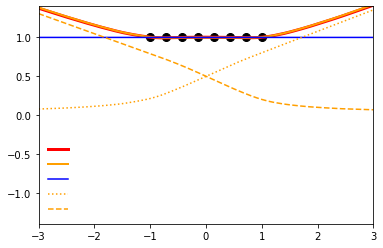

g(0)= 0.00015625000000000003
lambda_paper: 0.007104207847525956
60/60 [==============================] - 0s 1ms/step


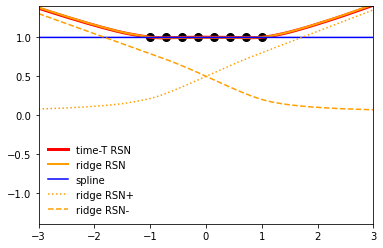

In [24]:
plot_f_advanced(model, modelRidge, radPlot=3, add_splitting_T=False,file_name='differenceAdaptedSplineVsWeightedSpline',y_min=-1.4,y_max=1.4)

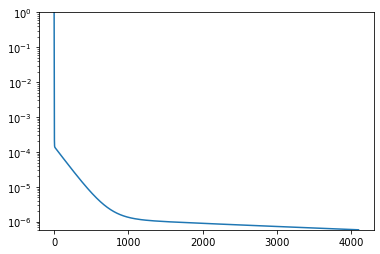

tr_time: 1024.0 , tr_time_paper: 128.0
lambda_tilde: 0.0002841683139010383 , lambda_tilde_paper: 0.0022733465112083065 , lambda_tilde equivalent formula: 0.0002841683139010383 , lambda_tilde_paper equivalent formula: 0.0022733465112083065
(8, 1024)
x_train:
(8, 1)
rescale_affine_weights:  1024.0
Ridge regression claculated successfull


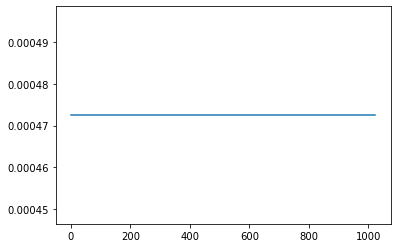

historyRidge.history['loss'][-1]: 0.0004724985046777874


In [15]:
(model,modelRidge,lambda_tilda) = train_both_models(lr=lr,
                x_train=x_train,
                y_train=y_train,
                batch_size=min(n_samples, 512),
                epoch_nr=epoch_nr,
                verbose=0,
                validation_data=(x_val, y_val),
                shuffle=True,
                weight_name=weight_name,
                n=n,
                s=s, seed=1, use_final_bias=True, linear_skip=True, din=1, l2reg_factor_affine_weights=2**(-20))

{'model': <keras.engine.functional.Functional object at 0x7faf40665ed0>, 'modelRidge': <keras.engine.functional.Functional object at 0x7fb00812e9e0>, 'radPlot': 3, 'x_min': None, 'x_max': None, 'y_min': -1.4, 'y_max': 1.4, 'legend_loc': None, 'frameon': False, 'add_splitting_T': False, 'add_splitting_ridge': True, 'file_name': 'differenceAdaptedSplineWithAffineVsWeightedSplineNoLabel', 'label_T': 'time-T RSN', 'label_ridge': 'ridge RSN', 'label_spline': 'spline', 'label_plus_T': 'time-T RSN+', 'label_minus_T': 'time-T RSN-', 'label_plus_ridge': 'ridge RSN+', 'label_minus_ridge': 'ridge RSN-', 'sign': 'b', 'add_to_plot': False, 'version_without_labels': False, 'legend_alpha': 0.0, 'framealpha': 0.8, 'LegendBoxEdgecolor': '0.8'}
g(0)= 0.00015625000000000003
lambda_paper: 0.007104207847525956
60/60 [==============================] - 0s 1ms/step


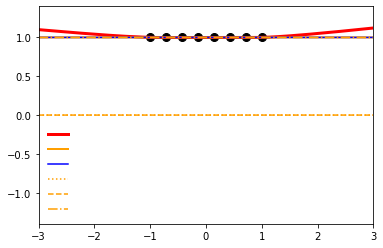

g(0)= 0.00015625000000000003
lambda_paper: 0.007104207847525956
60/60 [==============================] - 0s 1ms/step


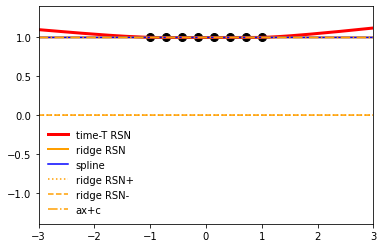

In [17]:
plot_f_advanced(model, modelRidge, radPlot=3, add_splitting_T=False,file_name='differenceAdaptedSplineWithAffineVsWeightedSpline',y_min=-1.4,y_max=1.4)

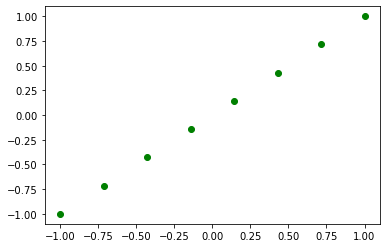

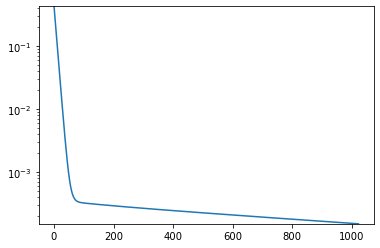

tr_time: 256.0 , tr_time_paper: 32.0
lambda_tilde: 0.0011366732556041532 , lambda_tilde_paper: 0.009093386044833226 , lambda_tilde equivalent formula: 0.0011366732556041532 , lambda_tilde_paper equivalent formula: 0.009093386044833226
(8, 1024)
x_train:
(8, 1)
rescale_affine_weights:  1.0
Ridge regression claculated successfull


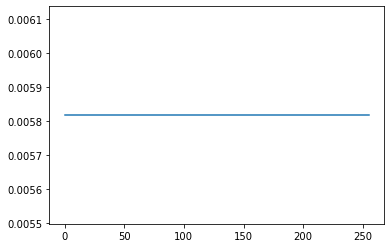

historyRidge.history['loss'][-1]: 0.0058171930722892284


In [18]:
tensorflow.random.set_seed(1)

d = 1  # output dimension
n_samples = 8  # number of samples
n_val= 2

# RSN parameter
s = 0.05  # range of random initialization
n = 1024  # number of hidden nodes

# training parameter
epoch_nr = 2**(10) #2**(12)  # number of epochs
lr = 2**(-2)  # learning rate
tr_time = epoch_nr*lr  # training time  (tr_time*n_samples = T_paper)
weight_name = "GrownUp2"+str(epoch_nr)+'_logT'+str(int(math.log(tr_time, 2)))+'.h5'


# training data
x_min = -1
x_max = 1
x_train = np.array(np.linspace(x_min, x_max, n_samples)).reshape(n_samples, d)
x_train = np.sort(x_train, 0)

# xrange for plots
resolution = 1920
x_smooth = np.array(np.linspace(x_min, x_max, resolution)).reshape(resolution, 1)

# training output #HERE YOU CAN CHANGE THE y-DATA BY REPLACING np.sin
y_train = (np.random.normal(scale=0,
                            size=n_samples)+x_train.reshape(n_samples))

# validation data
x_val = ((np.random.rand(n_val, d)-0.5)*2.0).reshape(n_val, d)
y_val = np.sin(np.pi*x_val[:, 0])*0+1

# plot training (and validation data)
plt.plot(x_train, y_train,'go')
#plt.plot(x_val, y_val,'k.')
plt.show()

(model,modelRidge,lambda_tilda) = train_both_models(lr=lr,
                x_train=x_train,
                y_train=y_train,
                batch_size=min(n_samples, 512),
                epoch_nr=epoch_nr,
                verbose=0,
                validation_data=(x_val, y_val),
                shuffle=True,
                weight_name=weight_name,
                n=n,
                s=s, seed=1, use_final_bias=False, linear_skip=False, din=1, l2reg_factor_affine_weights=1)

# model = createModel(n=n, l2reg=0, use_final_bias=False)

# (model,modelRidge,lambda_tilda) = train_both_models(model,
#                 lr=lr,
#                 x_train=x_train,
#                 y_train=y_train,
#                 batch_size=min(n_samples, 512),
#                 epoch_nr=epoch_nr,
#                 verbose=0,
#                 validation_data=(x_val, y_val),
#                 shuffle=True,
#                 weight_name=weight_name)

{'model': <keras.engine.functional.Functional object at 0x7faf407b1000>, 'modelRidge': <keras.engine.functional.Functional object at 0x7faf48375b10>, 'radPlot': 3, 'x_min': None, 'x_max': None, 'y_min': None, 'y_max': None, 'legend_loc': None, 'frameon': False, 'add_splitting_T': False, 'add_splitting_ridge': True, 'file_name': 'LinearDifferenceAdaptedSplineVsWeightedSplineNoLabel', 'label_T': 'time-T RSN', 'label_ridge': 'ridge RSN', 'label_spline': 'spline', 'label_plus_T': 'time-T RSN+', 'label_minus_T': 'time-T RSN-', 'label_plus_ridge': 'ridge RSN+', 'label_minus_ridge': 'ridge RSN-', 'sign': 'b', 'add_to_plot': False, 'version_without_labels': False, 'legend_alpha': 0.0, 'framealpha': 0.8, 'LegendBoxEdgecolor': '0.8'}
g(0)= 0.00015625000000000003
lambda_paper: 0.028416831390103824
60/60 [==============================] - 0s 1ms/step


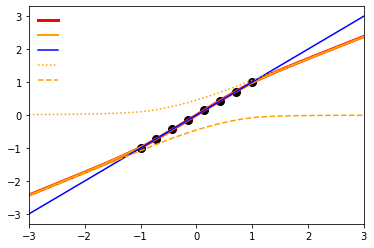

g(0)= 0.00015625000000000003
lambda_paper: 0.028416831390103824
60/60 [==============================] - 0s 1ms/step


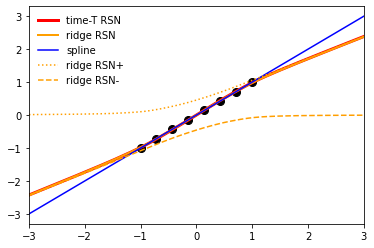

In [19]:
plot_f_advanced(model, modelRidge, radPlot=3, add_splitting_T=False,file_name='LinearDifferenceAdaptedSplineVsWeightedSpline')

# # %%
# # fit spline regression with g(0) and regularizing parameter lambda (lamb)
# # as in the paper including an adjustment for the scaling of lamb
# # (see https://stats.stackexchange.com/a/430482/261315)


# g_Zero = s**2/8/2 
# print('g(0)=', g_Zero)
# lamb = float((n_samples*lambda_tilda/(2*g_Zero)/n)/(max(x_train)-min(x_train))**3) 

# spline = splineFit(x_train, y_train, lamb)


# # %%
# # visualize result

# radPlot = 3
# xPlot = np.linspace(-radPlot, radPlot, 1920)
# ySpline = splinePredict(spline, xPlot)
# yminPlot = min(np.min(model.predict(xPlot)),
#                np.min(modelRidge.predict(xPlot)))-0.05
# ymaxPlot = max(np.max(model.predict(xPlot)),
#                np.max(modelRidge.predict(xPlot)))+0.05
  
# plt.plot(x_train, y_train, 'ko', markersize=8) 
# plt.plot(xPlot, model.predict(xPlot), 'r-', linewidth=3, label='time-T RSN')
# plt.plot(xPlot, modelRidge.predict(xPlot), '-', linewidth=2,
#          color=(1, 5/8, 0.0), label='ridge RSN')
# plt.plot(xPlot, ySpline, 'b-', linewidth=2, label='spline')
  
# plt.ylim(-2.5, 2.5)
# plt.xlim(-radPlot, radPlot)
 
# plt.legend(loc='upper left', frameon=False)
# plt.savefig('LinearDifferenceAdaptedSplineVsWeightedSpline.svg', format='svg',transparent=True)
# plt.savefig('LinearDifferenceAdaptedSplineVsWeightedSpline.pdf', format='pdf',transparent=True)

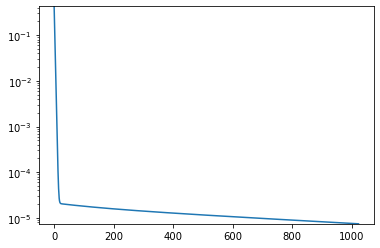

tr_time: 256.0 , tr_time_paper: 32.0
lambda_tilde: 0.0011366732556041532 , lambda_tilde_paper: 0.009093386044833226 , lambda_tilde equivalent formula: 0.0011366732556041532 , lambda_tilde_paper equivalent formula: 0.009093386044833226
(8, 1024)
x_train:
(8, 1)
rescale_affine_weights:  1024.0
Ridge regression claculated successfull


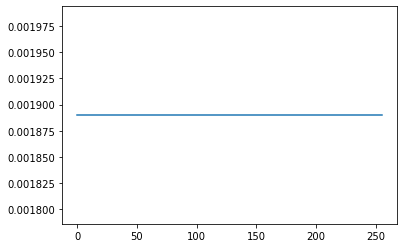

historyRidge.history['loss'][-1]: 0.0018899940187111497


In [20]:
(model,modelRidge,lambda_tilda) = train_both_models(lr=lr,
                x_train=x_train,
                y_train=y_train,
                batch_size=min(n_samples, 512),
                epoch_nr=epoch_nr,
                verbose=0,
                validation_data=(x_val, y_val),
                shuffle=True,
                weight_name=weight_name,
                n=n,
                s=s, seed=1, use_final_bias=True, linear_skip=True, din=1, l2reg_factor_affine_weights=2**(-20))

{'model': <keras.engine.functional.Functional object at 0x7faf4860c2e0>, 'modelRidge': <keras.engine.functional.Functional object at 0x7fafa415c400>, 'radPlot': 3, 'x_min': None, 'x_max': None, 'y_min': None, 'y_max': None, 'legend_loc': None, 'frameon': False, 'add_splitting_T': False, 'add_splitting_ridge': True, 'file_name': 'LinearDifferenceAdaptedSplineWithAffineVsWeightedSplineNoLabel', 'label_T': 'time-T RSN', 'label_ridge': 'ridge RSN', 'label_spline': 'spline', 'label_plus_T': 'time-T RSN+', 'label_minus_T': 'time-T RSN-', 'label_plus_ridge': 'ridge RSN+', 'label_minus_ridge': 'ridge RSN-', 'sign': 'b', 'add_to_plot': False, 'version_without_labels': False, 'legend_alpha': 0.0, 'framealpha': 0.8, 'LegendBoxEdgecolor': '0.8'}
g(0)= 0.00015625000000000003
lambda_paper: 0.028416831390103824
60/60 [==============================] - 0s 1ms/step


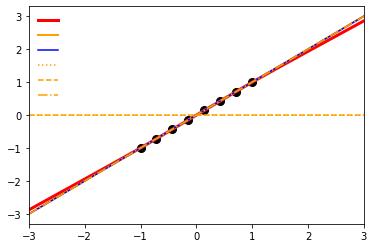

g(0)= 0.00015625000000000003
lambda_paper: 0.028416831390103824
60/60 [==============================] - 0s 1ms/step


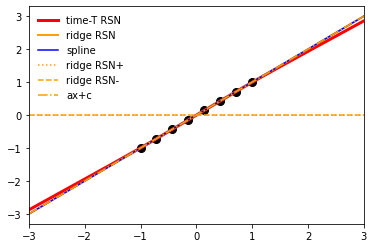

In [22]:
plot_f_advanced(model, modelRidge, radPlot=3, add_splitting_T=False,file_name='LinearDifferenceAdaptedSplineWithAffineVsWeightedSpline')

In [ ]:
stop

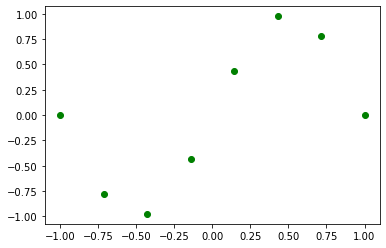

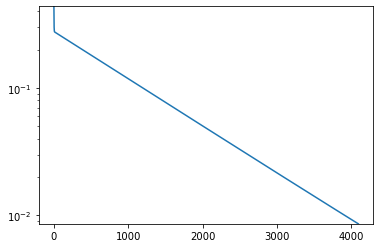

tr_time: 1024.0 , tr_time_paper: 128.0
lambda_tilde: 0.0002841683139010383 , lambda_tilde_paper: 0.0022733465112083065 , lambda_tilde equivalent formula: 0.0002841683139010383 , lambda_tilde_paper equivalent formula: 0.0022733465112083065
(8, 1024)
x_train:
(8, 1)
rescale_affine_weights:  32768.0
Ridge regression claculated successfull


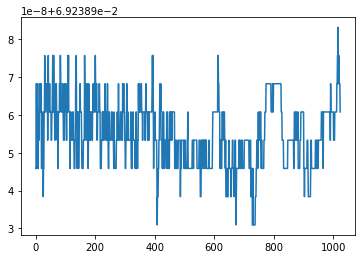

historyRidge.history['loss'][-1]: 0.06923896074295044


In [19]:
tensorflow.random.set_seed(1)

d = 1  # output dimension
n_samples = 8  # number of samples
n_val= 2

# RSN parameter
s = 0.05  # range of random initialization
n = 1024  # number of hidden nodes

# training parameter
epoch_nr = 2**(12) #2**(12)  # number of epochs
lr = 2**(-2)  # learning rate
tr_time = epoch_nr*lr  # training time  (tr_time*n_samples = T_paper)
weight_name = "GrownUp2"+str(epoch_nr)+'_logT'+str(int(math.log(tr_time, 2)))+'.h5'


# training data
x_min = -1
x_max = 1
x_train = np.array(np.linspace(x_min, x_max, n_samples)).reshape(n_samples, d)
x_train = np.sort(x_train, 0)

# xrange for plots
resolution = 1920
x_smooth = np.array(np.linspace(x_min, x_max, resolution)).reshape(resolution, 1)

# training output #HERE YOU CAN CHANGE THE y-DATA BY REPLACING np.sin
y_train = (np.random.normal(scale=0,
                            size=n_samples)+np.sin(np.pi*x_train).reshape(n_samples))

# validation data
x_val = ((np.random.rand(n_val, d)-0.5)*2.0).reshape(n_val, d)
y_val = np.sin(np.pi*x_val[:, 0])*0+1

# plot training (and validation data)
plt.plot(x_train, y_train,'go')
#plt.plot(x_val, y_val,'k.')
plt.show()

(model,modelRidge,lambda_tilda) = train_both_models(lr=lr,
                x_train=x_train,
                y_train=y_train,
                batch_size=min(n_samples, 512),
                epoch_nr=epoch_nr,
                verbose=0,
                validation_data=(x_val, y_val),
                shuffle=True,
                weight_name=weight_name,
                n=n,
                s=s, seed=1, use_final_bias=True, linear_skip=True, din=1, l2reg_factor_affine_weights=2**(-30))


{'model': <keras.engine.functional.Functional object at 0x7efe183db1f0>, 'modelRidge': <keras.engine.functional.Functional object at 0x7efdf87c1d50>, 'radPlot': 2, 'x_min': None, 'x_max': None, 'y_min': None, 'y_max': None, 'legend_loc': None, 'frameon': False, 'add_splitting_T': False, 'add_splitting_ridge': True, 'file_name': 'SinWithAffineWeightsNoLabel', 'label_T': 'time-T RSN', 'label_ridge': 'ridge RSN', 'label_spline': 'spline', 'label_plus_T': 'time-T RSN+', 'label_minus_T': 'time-T RSN-', 'label_plus_ridge': 'ridge RSN+', 'label_minus_ridge': 'ridge RSN-', 'sign': 'b', 'add_to_plot': False, 'version_without_labels': False, 'legend_alpha': 0.0}
g(0)= 0.00015625000000000003
lambda_paper: 0.007104207847525956
60/60 [==============================] - 0s 1ms/step


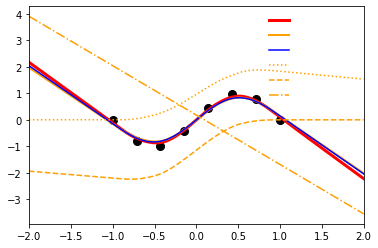

g(0)= 0.00015625000000000003
lambda_paper: 0.007104207847525956
60/60 [==============================] - 0s 1ms/step


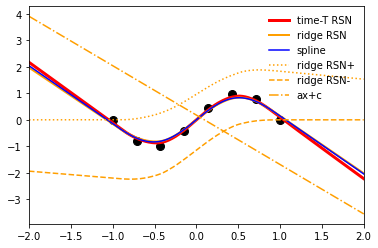

In [20]:
plot_f_advanced(model, modelRidge, radPlot=2, add_splitting_T=False,file_name='SinWithAffineWeights')


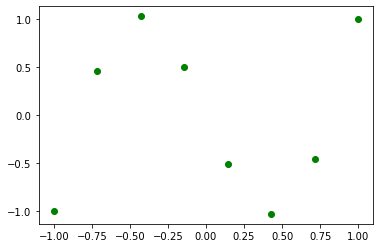

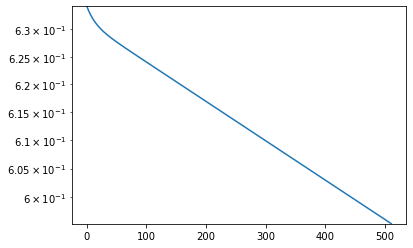

tr_time: 16.0 , tr_time_paper: 2.0
lambda_tilde: 0.01818677208966645 , lambda_tilde_paper: 0.1454941767173316 , lambda_tilde equivalent formula: 0.01818677208966645 , lambda_tilde_paper equivalent formula: 0.1454941767173316
(8, 1024)
x_train:
(8, 1)
rescale_affine_weights:  1.0
Ridge regression claculated successfull


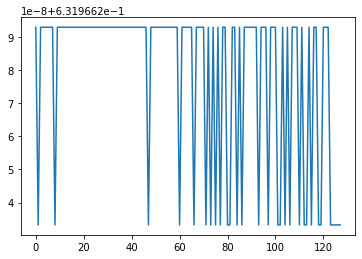

historyRidge.history['loss'][-1]: 0.631966233253479


In [21]:
tensorflow.random.set_seed(1)

d = 1  # output dimension
n_samples = 8  # number of samples
n_val= 2

# RSN parameter
s = 0.05  # range of random initialization
n = 1024  # number of hidden nodes

# training parameter
epoch_nr = 2**(9) #2**(12)  # number of epochs
lr = 2**(-5)  # learning rate
tr_time = epoch_nr*lr  # training time  (tr_time*n_samples = T_paper)
weight_name = "GrownUp2"+str(epoch_nr)+'_logT'+str(int(math.log(tr_time, 2)))+'.h5'


# training data
x_min = -1
x_max = 1
x_train = np.array(np.linspace(x_min, x_max, n_samples)).reshape(n_samples, d)
x_train = np.sort(x_train, 0)

# xrange for plots
resolution = 1920
x_smooth = np.array(np.linspace(x_min, x_max, resolution)).reshape(resolution, 1)

# training output #HERE YOU CAN CHANGE THE y-DATA BY REPLACING np.sin
y_train = (np.random.normal(scale=0,
                            size=n_samples)+x_train.reshape(n_samples)-1.5*np.sin(np.pi*x_train).reshape(n_samples))

# validation data
x_val = ((np.random.rand(n_val, d)-0.5)*2.0).reshape(n_val, d)
y_val = np.sin(np.pi*x_val[:, 0])*0+1

# plot training (and validation data)
plt.plot(x_train, y_train,'go')
#plt.plot(x_val, y_val,'k.')
plt.show()

(model,modelRidge,lambda_tilda) = train_both_models(lr=lr,
                x_train=x_train,
                y_train=y_train,
                batch_size=min(n_samples, 512),
                epoch_nr=epoch_nr,
                verbose=0,
                validation_data=(x_val, y_val),
                shuffle=True,
                weight_name=weight_name,
                n=n,
                s=s, seed=None, use_final_bias=True, linear_skip=True, din=1, l2reg_factor_affine_weights=2**(-15*0))


{'model': <keras.engine.functional.Functional object at 0x7efdf830d600>, 'modelRidge': <keras.engine.functional.Functional object at 0x7efdf84d6110>, 'radPlot': 2, 'x_min': None, 'x_max': None, 'y_min': None, 'y_max': None, 'legend_loc': None, 'frameon': False, 'add_splitting_T': True, 'add_splitting_ridge': True, 'file_name': 'withAffineWeightsNoLabel', 'label_T': 'time-T RSN', 'label_ridge': 'ridge RSN', 'label_spline': 'spline', 'label_plus_T': 'time-T RSN+', 'label_minus_T': 'time-T RSN-', 'label_plus_ridge': 'ridge RSN+', 'label_minus_ridge': 'ridge RSN-', 'sign': 'b', 'add_to_plot': False, 'version_without_labels': False, 'legend_alpha': 0.0}
g(0)= 0.00015625000000000003
lambda_paper: 0.4546693022416612
60/60 [==============================] - 0s 1ms/step


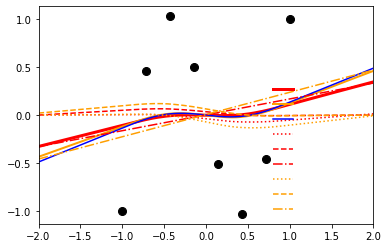

g(0)= 0.00015625000000000003
lambda_paper: 0.4546693022416612
60/60 [==============================] - 0s 1ms/step


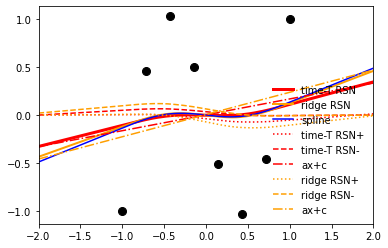

In [22]:
plot_f_advanced(model, modelRidge, radPlot=2, add_splitting_T=True,file_name='withAffineWeights')

In [23]:
#print(model.get_layer(name="myOutputLayer").get_weights()[1])
#print(modelRidge.get_layer(name="myOutputLayer").get_weights()[1])
#plot_f_advanced(model, modelRidge, radPlot=2, add_splitting_T=False,file_name='withAffineWeights')


In [24]:
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 myHiddenLayer (Dense)          (None, 1024)         2048        ['input[0][0]']                  
                                                                                                  
 myOutputLayer (Dense)          (None, 1)            1025        ['myHiddenLayer[0][0]']          
                                                                                                  
 myLinearSkipLayer (Dense)      (None, 1)            1           ['input[0][0]']                  
                                                                                           

In [25]:
modelRidge.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 myHiddenLayer (Dense)          (None, 1024)         2048        ['input[0][0]']                  
                                                                                                  
 myOutputLayer (Dense)          (None, 1)            1025        ['myHiddenLayer[0][0]']          
                                                                                                  
 myLinearSkipLayer (Dense)      (None, 1)            1           ['input[0][0]']                  
                                                                                           

In [26]:
print("model.get_weights()[1]")
print(model.get_weights()[1])
print("model.get_weights()")
model.get_weights()

model.get_weights()[1]
[-0.02746814 -0.04662209 -0.03940034 ...  0.04158491 -0.01397495
  0.04149211]
model.get_weights()


[array([[ 0.04494474, -0.0061428 , -0.02777255, ..., -0.00961518,
         -0.02744861,  0.00375314]], dtype=float32),
 array([-0.02746814, -0.04662209, -0.03940034, ...,  0.04158491,
        -0.01397495,  0.04149211], dtype=float32),
 array([[ 0.05396549],
        [ 0.        ],
        [ 0.        ],
        ...,
        [-0.00148158],
        [-0.03755347],
        [ 0.00073847]], dtype=float32),
 array([0.00277467], dtype=float32),
 array([[0.16608618]], dtype=float32)]

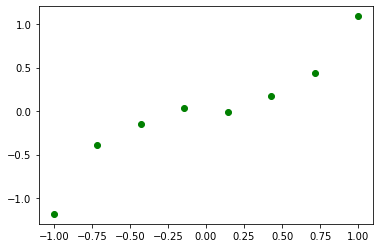

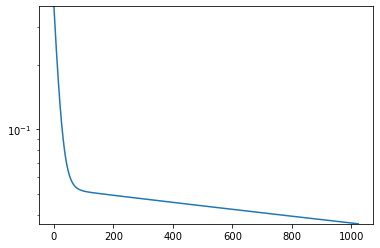

tr_time: 128.0 , tr_time_paper: 16.0
lambda_tilde: 0.0022733465112083065 , lambda_tilde_paper: 0.01818677208966645 , lambda_tilde equivalent formula: 0.0022733465112083065 , lambda_tilde_paper equivalent formula: 0.01818677208966645
(8, 1024)
x_train:
(8, 1)
rescale_affine_weights:  1.0
Ridge regression claculated successfull


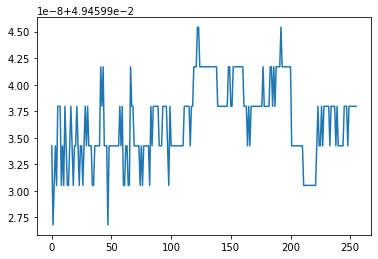

historyRidge.history['loss'][-1]: 0.04945993795990944


In [27]:
tensorflow.random.set_seed(1)

d = 1  # output dimension
n_samples = 8  # number of samples
n_val= 2

# RSN parameter
s = 0.05  # range of random initialization
n = 1024  # number of hidden nodes

# training parameter
epoch_nr = 2**(10) #2**7#2**(12)  # number of epochs
lr = 2**(-3) #1**(-6)  # learning rate
tr_time = epoch_nr*lr  # training time  (tr_time*n_samples = T_paper)
weight_name = "GrownUp2"+str(epoch_nr)+'_logT'+str(int(math.log(tr_time, 2)))+'.h5'


# training data
x_min = -1
x_max = 1
x_train = np.array(np.linspace(x_min, x_max, n_samples)).reshape(n_samples, d)
x_train = np.sort(x_train, 0)

# xrange for plots
resolution = 1920
x_smooth = np.array(np.linspace(x_min, x_max, resolution)).reshape(resolution, 1)

# training output #HERE YOU CAN CHANGE THE y-DATA BY REPLACING np.sin
y_train = (np.random.normal(scale=0.1,
                            size=n_samples)+(1.0*x_train**3).reshape(n_samples))

# validation data
x_val = ((np.random.rand(n_val, d)-0.5)*2.0).reshape(n_val, d)
y_val = np.sin(np.pi*x_val[:, 0])*0+1

# plot training (and validation data)
plt.plot(x_train, y_train,'go')
#plt.plot(x_val, y_val,'k.')
plt.show()

(model,modelRidge,lambda_tilda) = train_both_models(lr=lr,
                x_train=x_train,
                y_train=y_train,
                batch_size=min(n_samples, 512),
                epoch_nr=epoch_nr,
                verbose=0,
                validation_data=(x_val, y_val),
                shuffle=True,
                weight_name=weight_name,
                n=n,
                s=s, seed=None, use_final_bias=False, linear_skip=False, din=1, l2reg_factor_affine_weights=2**(-15*0))


{'model': <keras.engine.functional.Functional object at 0x7efe380a0130>, 'modelRidge': <keras.engine.functional.Functional object at 0x7efe38287280>, 'radPlot': 2, 'x_min': None, 'x_max': None, 'y_min': None, 'y_max': None, 'legend_loc': None, 'frameon': False, 'add_splitting_T': True, 'add_splitting_ridge': True, 'file_name': 'cubicWithAffineWeightsNoLabel', 'label_T': 'time-T RSN', 'label_ridge': 'ridge RSN', 'label_spline': 'spline', 'label_plus_T': 'time-T RSN+', 'label_minus_T': 'time-T RSN-', 'label_plus_ridge': 'ridge RSN+', 'label_minus_ridge': 'ridge RSN-', 'sign': 'b', 'add_to_plot': False, 'version_without_labels': False, 'legend_alpha': 0.0}
g(0)= 0.00015625000000000003
lambda_paper: 0.05683366278020765
60/60 [==============================] - 0s 1ms/step


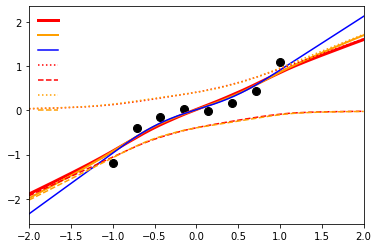

g(0)= 0.00015625000000000003
lambda_paper: 0.05683366278020765
60/60 [==============================] - 0s 1ms/step


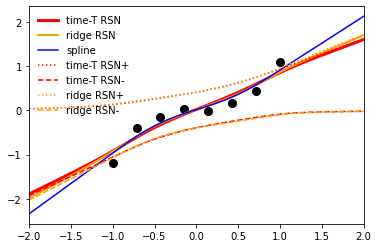

In [28]:
plot_f_advanced(model, modelRidge, radPlot=2, add_splitting_T=True,file_name='cubicWithAffineWeights')

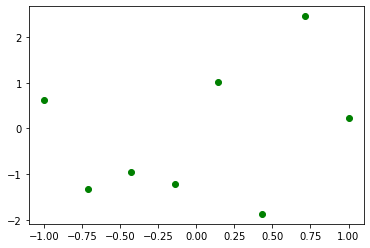

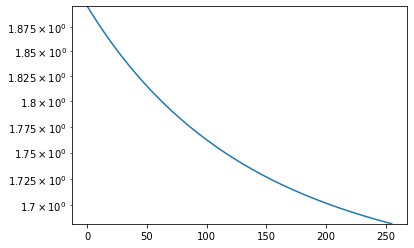

tr_time: 4.0 , tr_time_paper: 0.5
lambda_tilde: 0.0727470883586658 , lambda_tilde_paper: 0.5819767068693265 , lambda_tilde equivalent formula: 0.0727470883586658 , lambda_tilde_paper equivalent formula: 0.5819767068693265
(8, 1024)
x_train:
(8, 1)
rescale_affine_weights:  1.0
Ridge regression claculated successfull


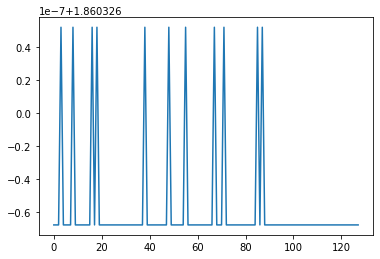

historyRidge.history['loss'][-1]: 1.8603259325027466


In [29]:
tensorflow.random.set_seed(1)
np.random.seed(1)

d = 1  # output dimension
n_samples = 8  # number of samples
n_val= 2

# RSN parameter
s = 0.05  # range of random initialization
n = 1024  # number of hidden nodes

# training parameter
epoch_nr = 2**(8) #2**7#2**(12)  # number of epochs
lr = 2**(-6) #1**(-6)  # learning rate
tr_time = epoch_nr*lr  # training time  (tr_time*n_samples = T_paper)
weight_name = "GrownUp2"+str(epoch_nr)+'_logT'+str(int(math.log(tr_time, 2)))+'.h5'


# training data
x_min = -1
x_max = 1
x_train = np.array(np.linspace(x_min, x_max, n_samples)).reshape(n_samples, d)
x_train = np.sort(x_train, 0)

# xrange for plots
resolution = 1920
x_smooth = np.array(np.linspace(x_min, x_max, resolution)).reshape(resolution, 1)

# training output #HERE YOU CAN CHANGE THE y-DATA BY REPLACING np.sin
y_train = (np.random.normal(scale=1.0,
                            size=n_samples)+(1.0*x_train).reshape(n_samples))

# validation data
x_val = ((np.random.rand(n_val, d)-0.5)*2.0).reshape(n_val, d)
y_val = np.sin(np.pi*x_val[:, 0])*0+1

# plot training (and validation data)
plt.plot(x_train, y_train,'go')
#plt.plot(x_val, y_val,'k.')
plt.show()

(model,modelRidge,lambda_tilda) = train_both_models(lr=lr,
                x_train=x_train,
                y_train=y_train,
                batch_size=min(n_samples, 512),
                epoch_nr=epoch_nr,
                verbose=0,
                validation_data=(x_val, y_val),
                shuffle=True,
                weight_name=weight_name,
                n=n,
                s=s, seed=None, use_final_bias=False, linear_skip=False, din=1, l2reg_factor_affine_weights=2**(-15*0))


{'model': <keras.engine.functional.Functional object at 0x7efe381956f0>, 'modelRidge': <keras.engine.functional.Functional object at 0x7efe1849b9a0>, 'radPlot': 2, 'x_min': None, 'x_max': None, 'y_min': None, 'y_max': None, 'legend_loc': None, 'frameon': False, 'add_splitting_T': False, 'add_splitting_ridge': True, 'file_name': 'linearNoiseStrongRegWithoutAffineWeightsNoLabel', 'label_T': 'time-T RSN', 'label_ridge': 'ridge RSN', 'label_spline': 'spline', 'label_plus_T': 'time-T RSN+', 'label_minus_T': 'time-T RSN-', 'label_plus_ridge': 'ridge RSN+', 'label_minus_ridge': 'ridge RSN-', 'sign': 'b', 'add_to_plot': False, 'version_without_labels': False, 'legend_alpha': 0.0}
g(0)= 0.00015625000000000003
lambda_paper: 1.8186772089666448
60/60 [==============================] - 0s 1ms/step


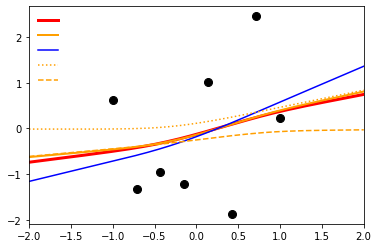

g(0)= 0.00015625000000000003
lambda_paper: 1.8186772089666448
60/60 [==============================] - 0s 1ms/step


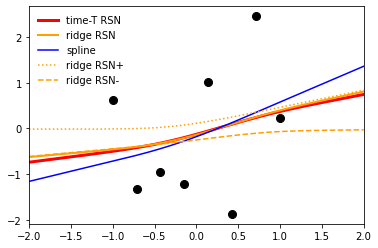

In [30]:
plot_f_advanced(model, modelRidge, radPlot=2, add_splitting_T=False,file_name='linearNoiseStrongRegWithoutAffineWeights')

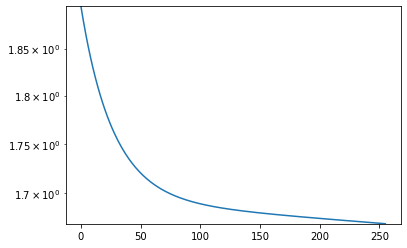

tr_time: 4.0 , tr_time_paper: 0.5
lambda_tilde: 0.0727470883586658 , lambda_tilde_paper: 0.5819767068693265 , lambda_tilde equivalent formula: 0.0727470883586658 , lambda_tilde_paper equivalent formula: 0.5819767068693265
(8, 1024)
x_train:
(8, 1)
rescale_affine_weights:  1024.0
Ridge regression claculated successfull


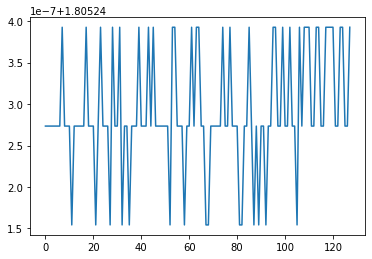

historyRidge.history['loss'][-1]: 1.8052403926849365


In [31]:
(model,modelRidge,lambda_tilda) = train_both_models(lr=lr,
                x_train=x_train,
                y_train=y_train,
                batch_size=min(n_samples, 512),
                epoch_nr=epoch_nr,
                verbose=0,
                validation_data=(x_val, y_val),
                shuffle=True,
                weight_name=weight_name,
                n=n,
                s=s, seed=None, use_final_bias=True, linear_skip=True, din=1, l2reg_factor_affine_weights=2**(-20))


{'model': <keras.engine.functional.Functional object at 0x7efdf82cd870>, 'modelRidge': <keras.engine.functional.Functional object at 0x7efe380cc4f0>, 'radPlot': 5, 'x_min': None, 'x_max': None, 'y_min': None, 'y_max': None, 'legend_loc': None, 'frameon': False, 'add_splitting_T': False, 'add_splitting_ridge': True, 'file_name': 'linearNoiseStrongRegWithAffineWeightsNoLabel', 'label_T': 'time-T RSN', 'label_ridge': 'ridge RSN', 'label_spline': 'spline', 'label_plus_T': 'time-T RSN+', 'label_minus_T': 'time-T RSN-', 'label_plus_ridge': 'ridge RSN+', 'label_minus_ridge': 'ridge RSN-', 'sign': 'b', 'add_to_plot': False, 'version_without_labels': False, 'legend_alpha': 0.0}
g(0)= 0.00015625000000000003
lambda_paper: 1.8186772089666448
60/60 [==============================] - 0s 1ms/step


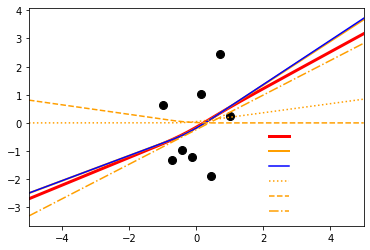

g(0)= 0.00015625000000000003
lambda_paper: 1.8186772089666448
60/60 [==============================] - 0s 1ms/step


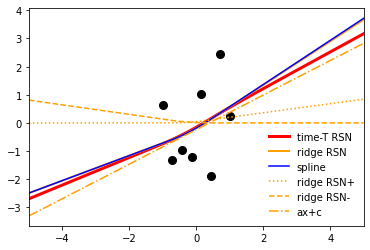

In [32]:
plot_f_advanced(model, modelRidge, radPlot=5, add_splitting_T=False,file_name='linearNoiseStrongRegWithAffineWeights')

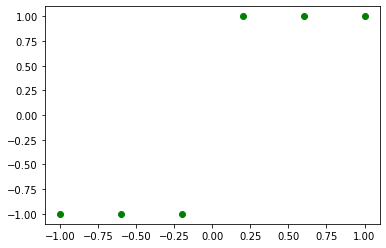

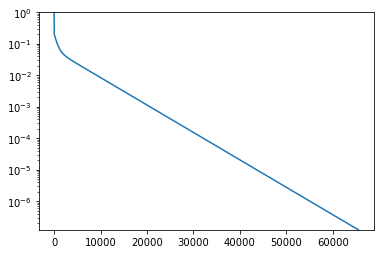

tr_time: 32768.0 , tr_time_paper: 5461.333333333333
lambda_tilde: 8.880259809407447e-06 , lambda_tilde_paper: 5.328155885644468e-05 , lambda_tilde equivalent formula: 8.880259809407447e-06 , lambda_tilde_paper equivalent formula: 5.328155885644469e-05
(6, 1024)
x_train:
(6, 1)
rescale_affine_weights:  1.0
Ridge regression claculated successfull


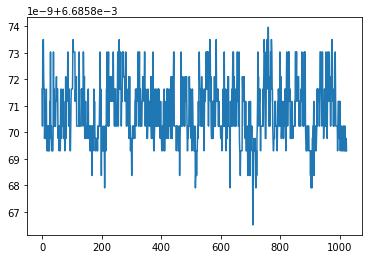

historyRidge.history['loss'][-1]: 0.006685869302600622


In [33]:
tensorflow.random.set_seed(1)
np.random.seed(1)

d = 1  # output dimension
n_samples = 6  # number of samples
n_val= 2

# RSN parameter
s = 0.05  # range of random initialization
n = 1024  # number of hidden nodes

# training parameter
epoch_nr = 2**(16) #2**7#2**(12)  # number of epochs
lr = 2**(-1) #1**(-6)  # learning rate
tr_time = epoch_nr*lr  # training time  (tr_time*n_samples = T_paper)
weight_name = "GrownUp2"+str(epoch_nr)+'_logT'+str(int(math.log(tr_time, 2)))+'.h5'


# training data
x_min = -1
x_max = 1
x_train = np.array(np.linspace(x_min, x_max, n_samples)).reshape(n_samples, d)
x_train = np.sort(x_train, 0)

# xrange for plots
resolution = 1920
x_smooth = np.array(np.linspace(x_min, x_max, resolution)).reshape(resolution, 1)

# training output #HERE YOU CAN CHANGE THE y-DATA BY REPLACING np.sin
y_train = (np.random.normal(scale=0.0,
                            size=n_samples)+(2.0*(x_train>0)-1).reshape(n_samples))

# validation data
x_val = ((np.random.rand(n_val, d)-0.5)*2.0).reshape(n_val, d)
y_val = np.sin(np.pi*x_val[:, 0])*0+1

# plot training (and validation data)
plt.plot(x_train, y_train,'go')
#plt.plot(x_val, y_val,'k.')
plt.show()

(model,modelRidge,lambda_tilda) = train_both_models(lr=lr,
                x_train=x_train,
                y_train=y_train,
                batch_size=min(n_samples, 512),
                epoch_nr=epoch_nr,
                verbose=0,
                validation_data=(x_val, y_val),
                shuffle=True,
                weight_name=weight_name,
                n=n,
                s=s, seed=None, use_final_bias=False, linear_skip=False, din=1, l2reg_factor_affine_weights=2**(-15*0))


{'model': <keras.engine.functional.Functional object at 0x7efe7c1422c0>, 'modelRidge': <keras.engine.functional.Functional object at 0x7efe1857ee00>, 'radPlot': 1.5, 'x_min': None, 'x_max': None, 'y_min': None, 'y_max': None, 'legend_loc': None, 'frameon': False, 'add_splitting_T': False, 'add_splitting_ridge': True, 'file_name': 'jumpWithoutAffineWeightsNoLabel', 'label_T': 'time-T RSN', 'label_ridge': 'ridge RSN', 'label_spline': 'spline', 'label_plus_T': 'time-T RSN+', 'label_minus_T': 'time-T RSN-', 'label_plus_ridge': 'ridge RSN+', 'label_minus_ridge': 'ridge RSN-', 'sign': 'b', 'add_to_plot': False, 'version_without_labels': False, 'legend_alpha': 0.0}
g(0)= 0.00015625000000000003
lambda_paper: 0.0001665048714263896
60/60 [==============================] - 0s 1ms/step


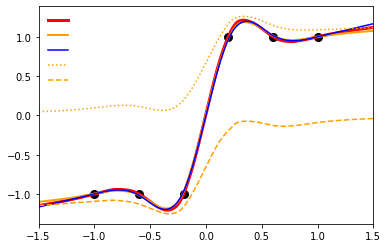

g(0)= 0.00015625000000000003
lambda_paper: 0.0001665048714263896
60/60 [==============================] - 0s 1ms/step


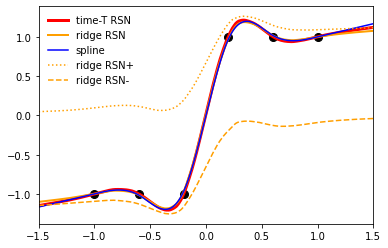

In [34]:
plot_f_advanced(model, modelRidge, radPlot=1.5, add_splitting_T=False,file_name='jumpWithoutAffineWeights')

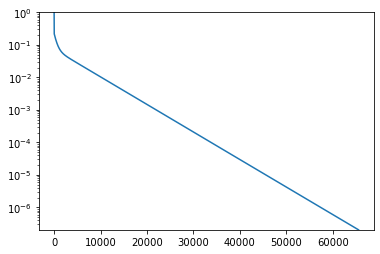

tr_time: 32768.0 , tr_time_paper: 5461.333333333333
lambda_tilde: 8.880259809407447e-06 , lambda_tilde_paper: 5.328155885644468e-05 , lambda_tilde equivalent formula: 8.880259809407447e-06 , lambda_tilde_paper equivalent formula: 5.328155885644469e-05
(6, 1024)
x_train:
(6, 1)
rescale_affine_weights:  32768.0
Ridge regression claculated successfull


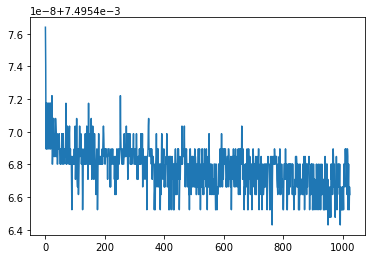

historyRidge.history['loss'][-1]: 0.007495466154068708


In [35]:
(model,modelRidge,lambda_tilda) = train_both_models(lr=lr,
                x_train=x_train,
                y_train=y_train,
                batch_size=min(n_samples, 512),
                epoch_nr=epoch_nr,
                verbose=0,
                validation_data=(x_val, y_val),
                shuffle=True,
                weight_name=weight_name,
                n=n,
                s=s, seed=None, use_final_bias=True, linear_skip=True, din=1, l2reg_factor_affine_weights=2**(-30))


{'model': <keras.engine.functional.Functional object at 0x7efe1828fa90>, 'modelRidge': <keras.engine.functional.Functional object at 0x7efe18761f90>, 'radPlot': 1.5, 'x_min': None, 'x_max': None, 'y_min': None, 'y_max': None, 'legend_loc': None, 'frameon': False, 'add_splitting_T': False, 'add_splitting_ridge': True, 'file_name': 'jumpWithAffineWeightsNoLabel', 'label_T': 'time-T RSN', 'label_ridge': 'ridge RSN', 'label_spline': 'spline', 'label_plus_T': 'time-T RSN+', 'label_minus_T': 'time-T RSN-', 'label_plus_ridge': 'ridge RSN+', 'label_minus_ridge': 'ridge RSN-', 'sign': 'b', 'add_to_plot': False, 'version_without_labels': False, 'legend_alpha': 0.0}
g(0)= 0.00015625000000000003
lambda_paper: 0.0001665048714263896
60/60 [==============================] - 0s 1ms/step


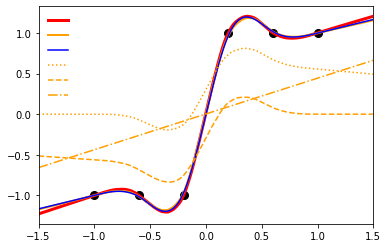

g(0)= 0.00015625000000000003
lambda_paper: 0.0001665048714263896
60/60 [==============================] - 0s 1ms/step


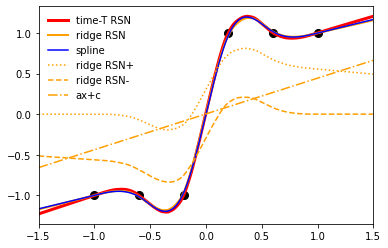

In [36]:
plot_f_advanced(model, modelRidge, radPlot=1.5, add_splitting_T=False,file_name='jumpWithAffineWeights')

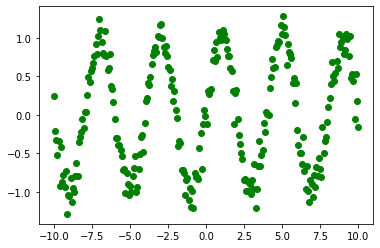

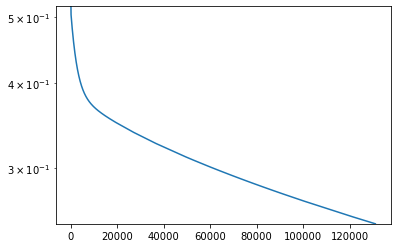

tr_time: 16384.0 , tr_time_paper: 64.0
lambda_tilde: 1.7760519618814894e-05 , lambda_tilde_paper: 0.004546693022416613 , lambda_tilde equivalent formula: 1.7760519618814894e-05 , lambda_tilde_paper equivalent formula: 0.004546693022416613
(256, 1024)
x_train:
(256, 1)
rescale_affine_weights:  1.0
Ridge regression claculated successfull


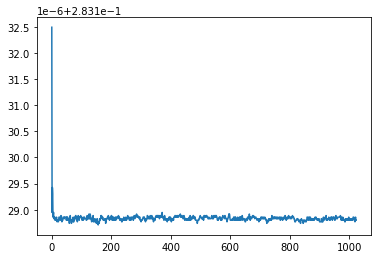

historyRidge.history['loss'][-1]: 0.2831287980079651


In [37]:
tensorflow.random.set_seed(1)
np.random.seed(1)

d = 1  # output dimension
n_samples = 256  # number of samples
n_val= 2

# RSN parameter
s = 0.05  # range of random initialization
n = 1024  # number of hidden nodes

# training parameter
epoch_nr = 2**(17) #2**7#2**(12)  # number of epochs
lr = 2**(-3) #1**(-6)  # learning rate
tr_time = epoch_nr*lr  # training time  (tr_time*n_samples = T_paper)
weight_name = "GrownUp2"+str(epoch_nr)+'_logT'+str(int(math.log(tr_time, 2)))+'.h5'


# training data
x_min = -10
x_max = 10
x_train = np.array(np.linspace(x_min, x_max, n_samples)).reshape(n_samples, d)
x_train = np.sort(x_train, 0)

# xrange for plots
resolution = 1920
x_smooth = np.array(np.linspace(x_min, x_max, resolution)).reshape(resolution, 1)

# training output #HERE YOU CAN CHANGE THE y-DATA BY REPLACING np.sin
y_train = (np.random.normal(scale=0.15,
                            size=n_samples)+(np.sin(0.5*np.pi*x_train)).reshape(n_samples))

# validation data
x_val = ((np.random.rand(n_val, d)-0.5)*2.0).reshape(n_val, d)
y_val = np.sin(np.pi*x_val[:, 0])*0+1

# plot training (and validation data)
plt.plot(x_train, y_train,'go')
#plt.plot(x_val, y_val,'k.')
plt.show()

(model,modelRidge,lambda_tilda) = train_both_models(lr=lr,
                x_train=x_train,
                y_train=y_train,
                batch_size=min(n_samples, 512),
                epoch_nr=epoch_nr,
                verbose=0,
                validation_data=(x_val, y_val),
                shuffle=True,
                weight_name=weight_name,
                n=n,
                s=s, seed=None, use_final_bias=False, linear_skip=False, din=1, l2reg_factor_affine_weights=2**(-15*0))


{'model': <keras.engine.functional.Functional object at 0x7efe18519000>, 'modelRidge': <keras.engine.functional.Functional object at 0x7efe38141ff0>, 'radPlot': 10, 'x_min': None, 'x_max': None, 'y_min': None, 'y_max': None, 'legend_loc': None, 'frameon': False, 'add_splitting_T': False, 'add_splitting_ridge': True, 'file_name': 'wideXrangeWithoutAffineWeightsNoLabel', 'label_T': 'time-T RSN', 'label_ridge': 'ridge RSN', 'label_spline': 'spline', 'label_plus_T': 'time-T RSN+', 'label_minus_T': 'time-T RSN-', 'label_plus_ridge': 'ridge RSN+', 'label_minus_ridge': 'ridge RSN-', 'sign': 'b', 'add_to_plot': False, 'version_without_labels': False, 'legend_alpha': 0.0}
g(0)= 0.00015625000000000003
lambda_paper: 0.014208415695051912
60/60 [==============================] - 0s 1ms/step


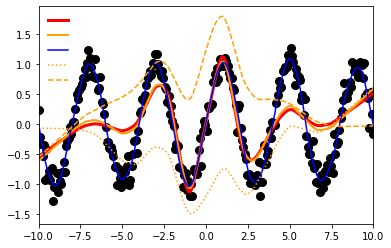

g(0)= 0.00015625000000000003
lambda_paper: 0.014208415695051912
60/60 [==============================] - 0s 1ms/step


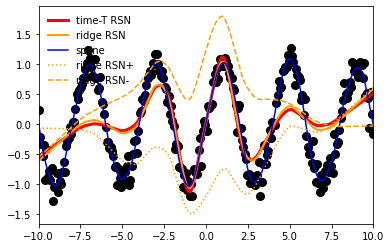

In [38]:
plot_f_advanced(model, modelRidge, radPlot=10, add_splitting_T=False,file_name='wideXrangeWithoutAffineWeights')

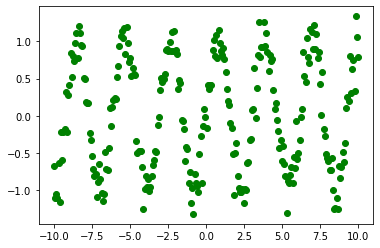

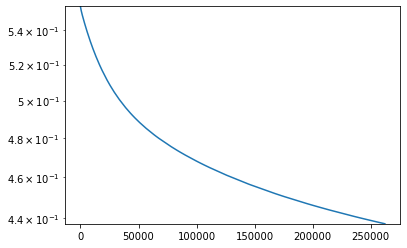

tr_time: 4096.0 , tr_time_paper: 16.0
lambda_tilde: 7.104207847525958e-05 , lambda_tilde_paper: 0.01818677208966645 , lambda_tilde equivalent formula: 7.104207847525958e-05 , lambda_tilde_paper equivalent formula: 0.01818677208966645
(256, 1024)
x_train:
(256, 1)
rescale_affine_weights:  1.0
Ridge regression claculated successfull


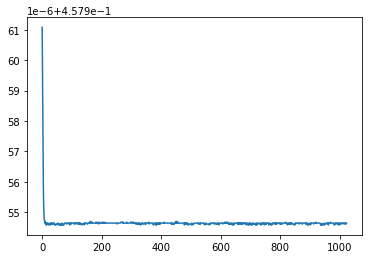

historyRidge.history['loss'][-1]: 0.45795464515686035


In [39]:
tensorflow.random.set_seed(1)
np.random.seed(1)

d = 1  # output dimension
n_samples = 256  # number of samples
n_val= 2

# RSN parameter
s = 0.05  # range of random initialization
n = 1024  # number of hidden nodes

# training parameter
epoch_nr = 2**(18) #2**7#2**(12)  # number of epochs
lr = 2**(-6) #1**(-6)  # learning rate
tr_time = epoch_nr*lr  # training time  (tr_time*n_samples = T_paper)
weight_name = "GrownUp2"+str(epoch_nr)+'_logT'+str(int(math.log(tr_time, 2)))+'.h5'


# training data
x_min = -10
x_max = 10
x_train = np.array(np.linspace(x_min, x_max, n_samples)).reshape(n_samples, d)
x_train = np.sort(x_train, 0)

# xrange for plots
resolution = 1920
x_smooth = np.array(np.linspace(x_min, x_max, resolution)).reshape(resolution, 1)

# training output #HERE YOU CAN CHANGE THE y-DATA BY REPLACING np.sin
y_train = (np.random.normal(scale=0.2,
                            size=n_samples)+(np.sin(6.5/10*np.pi*x_train)).reshape(n_samples))

# validation data
x_val = ((np.random.rand(n_val, d)-0.5)*2.0).reshape(n_val, d)
y_val = np.sin(np.pi*x_val[:, 0])*0+1

# plot training (and validation data)
plt.plot(x_train, y_train,'go')
#plt.plot(x_val, y_val,'k.')
plt.show()

(model,modelRidge,lambda_tilda) = train_both_models(lr=lr,
                x_train=x_train,
                y_train=y_train,
                batch_size=min(n_samples, 512),
                epoch_nr=epoch_nr,
                verbose=0,
                validation_data=(x_val, y_val),
                shuffle=True,
                weight_name=weight_name,
                n=n,
                s=s, seed=None, use_final_bias=False, linear_skip=False, din=1, l2reg_factor_affine_weights=2**(-15*0))


{'model': <keras.engine.functional.Functional object at 0x7efe706a6560>, 'modelRidge': <keras.engine.functional.Functional object at 0x7efe3811ece0>, 'radPlot': 10, 'x_min': None, 'x_max': None, 'y_min': None, 'y_max': None, 'legend_loc': None, 'frameon': False, 'add_splitting_T': False, 'add_splitting_ridge': True, 'file_name': 'wideXrangeWithoutAffineWeightsMoreEpochsNoLabel', 'label_T': 'time-T RSN', 'label_ridge': 'ridge RSN', 'label_spline': 'spline', 'label_plus_T': 'time-T RSN+', 'label_minus_T': 'time-T RSN-', 'label_plus_ridge': 'ridge RSN+', 'label_minus_ridge': 'ridge RSN-', 'sign': 'b', 'add_to_plot': False, 'version_without_labels': False, 'legend_alpha': 0.0}
g(0)= 0.00015625000000000003
lambda_paper: 0.05683366278020765
60/60 [==============================] - 0s 1ms/step


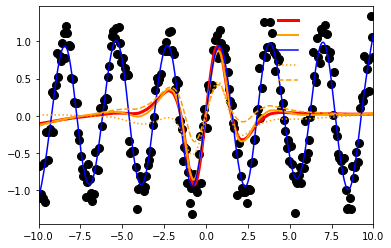

g(0)= 0.00015625000000000003
lambda_paper: 0.05683366278020765
60/60 [==============================] - 0s 995us/step


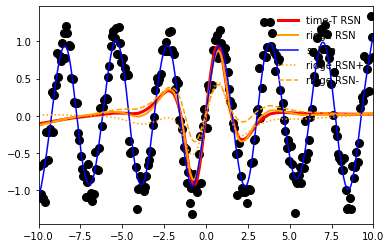

In [40]:
plot_f_advanced(model, modelRidge, radPlot=10, add_splitting_T=False,file_name='wideXrangeWithoutAffineWeightsMoreEpochs')

In [ ]:
plot_f_advanced(model, modelRidge, radPlot=10, add_splitting_T=False,file_name='wideXrangeWithoutAffineWeightsMoreEpochswhiteLegend',legend_alpha=1.0, frameon=True,framealpha=0.85,LegendBoxEdgecolor='white')

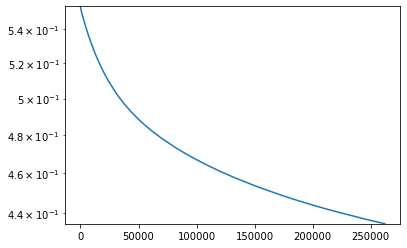

tr_time: 4096.0 , tr_time_paper: 16.0
lambda_tilde: 7.104207847525958e-05 , lambda_tilde_paper: 0.01818677208966645 , lambda_tilde equivalent formula: 7.104207847525958e-05 , lambda_tilde_paper equivalent formula: 0.01818677208966645
(256, 1024)
x_train:
(256, 1)
rescale_affine_weights:  1024.0
Ridge regression claculated successfull


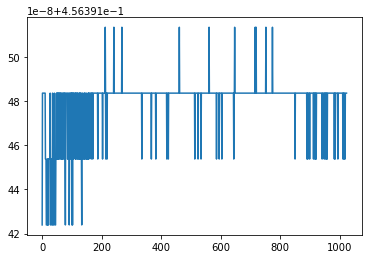

historyRidge.history['loss'][-1]: 0.45639148354530334


In [41]:
(model,modelRidge,lambda_tilda) = train_both_models(lr=lr,
                x_train=x_train,
                y_train=y_train,
                batch_size=min(n_samples, 512),
                epoch_nr=epoch_nr,
                verbose=0,,frameon=True,framealpha=0.85,LegendBoxEdgecolor='white'
                validation_data=(x_val, y_val),
                shuffle=True,
                weight_name=weight_name,
                n=n,
                s=s, seed=None, use_final_bias=True, linear_skip=True, din=1, l2reg_factor_affine_weights=2**(-20))


{'model': <keras.engine.functional.Functional object at 0x7efdf8646080>, 'modelRidge': <keras.engine.functional.Functional object at 0x7efe70539c90>, 'radPlot': 10, 'x_min': None, 'x_max': None, 'y_min': None, 'y_max': None, 'legend_loc': None, 'frameon': False, 'add_splitting_T': False, 'add_splitting_ridge': True, 'file_name': 'wideXrangeWithAffineWeightsMoreEpochsNoLabel', 'label_T': 'time-T RSN', 'label_ridge': 'ridge RSN', 'label_spline': 'spline', 'label_plus_T': 'time-T RSN+', 'label_minus_T': 'time-T RSN-', 'label_plus_ridge': 'ridge RSN+', 'label_minus_ridge': 'ridge RSN-', 'sign': 'b', 'add_to_plot': False, 'version_without_labels': False, 'legend_alpha': 0.0}
g(0)= 0.00015625000000000003
lambda_paper: 0.05683366278020765
60/60 [==============================] - 0s 1ms/step


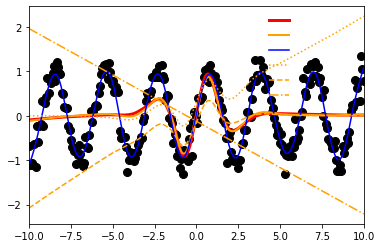

g(0)= 0.00015625000000000003
lambda_paper: 0.05683366278020765
60/60 [==============================] - 0s 1ms/step


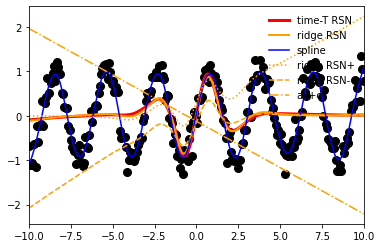

In [42]:
plot_f_advanced(model, modelRidge, radPlot=10, add_splitting_T=False,file_name='wideXrangeWithAffineWeightsMoreEpochs')

{'model': <keras.engine.functional.Functional object at 0x7efdf8646080>, 'modelRidge': <keras.engine.functional.Functional object at 0x7efe70539c90>, 'radPlot': 10, 'x_min': None, 'x_max': None, 'y_min': None, 'y_max': None, 'legend_loc': None, 'frameon': True, 'add_splitting_T': False, 'add_splitting_ridge': True, 'file_name': 'wideXrangeWithAffineWeightsMoreEpochswhiteLegendNoLabel', 'label_T': 'time-T RSN', 'label_ridge': 'ridge RSN', 'label_spline': 'spline', 'label_plus_T': 'time-T RSN+', 'label_minus_T': 'time-T RSN-', 'label_plus_ridge': 'ridge RSN+', 'label_minus_ridge': 'ridge RSN-', 'sign': 'b', 'add_to_plot': False, 'version_without_labels': False, 'legend_alpha': 0.0, 'framealpha': 0.85, 'LegendBoxEdgecolor': 'white'}
g(0)= 0.00015625000000000003
lambda_paper: 0.05683366278020765
60/60 [==============================] - 0s 1ms/step


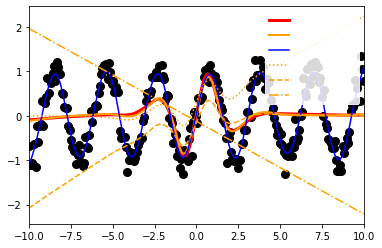

g(0)= 0.00015625000000000003
lambda_paper: 0.05683366278020765
60/60 [==============================] - 0s 1ms/step


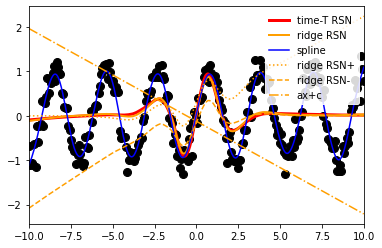

In [65]:
plot_f_advanced(model, modelRidge, radPlot=10, add_splitting_T=False,file_name='wideXrangeWithAffineWeightsMoreEpochswhiteLegend',legend_alpha=1.0, frameon=True,framealpha=0.85,LegendBoxEdgecolor='white')

In [51]:
print("Hello")
model.summary()

Hello
Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 myHiddenLayer (Dense)          (None, 1024)         2048        ['input[0][0]']                  
                                                                                                  
 myOutputLayer (Dense)          (None, 1)            1025        ['myHiddenLayer[0][0]']          
                                                                                                  
 myLinearSkipLayer (Dense)      (None, 1)            1           ['input[0][0]']                  
                                                                                     

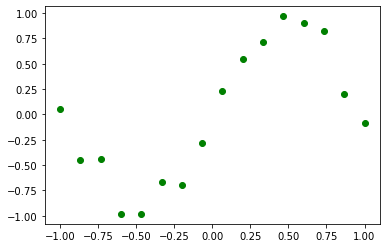

In [72]:
np.random.seed(seed=3+2)  # set seed

d = 1  # output dimension
n_samples = 16  # number of samples
n_val= 2

# RSN parameter
s = 0.05  # range of random initialization
n = 1024  # number of hidden nodes

# training parameter
epoch_nr = 2**19 #middle:2**(16) #2**7#2**(12)  # number of epochs
lr = 2**(-1) #middle:2**(-3) #1**(-6)  # learning rate
tr_time = epoch_nr*lr  # training time  (tr_time*n_samples = T_paper)
weight_name = "sin"+str(epoch_nr)+'_logT'+str(int(math.log(tr_time, 2)))+'.h5'

# RSN parameter
s = 0.05  # range of random initialization
n = 1024  # number of hidden nodes



# training data
x_min = -1
x_max = 1
x_train = np.array(np.linspace(x_min, x_max, n_samples)).reshape(n_samples, d)
x_train = np.sort(x_train, 0)

# xrange for plots
resolution = 1920
x_smooth = np.array(np.linspace(x_min, x_max, resolution)).reshape(resolution, 1)

y_min = -500.6
y_max = 500.6

# training output #HERE YOU CAN CHANGE THE y-DATA BY REPLACING np.sin
y_train = (np.random.normal(scale=1/8,
                            size=n_samples)+np.sin(np.pi*x_train[:, 0]))

# validation data
x_val = ((np.random.rand(n_val, d)-0.5)*2.0).reshape(n_val, d)
y_val = np.sin(np.pi*x_val[:, 0])*0+1

# plot training (and validation data)
plt.plot(x_train, y_train,'go')
#plt.plot(x_val, y_val,'k.')
plt.show()

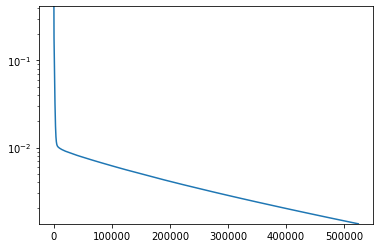

tr_time: 262144.0 , tr_time_paper: 16384.0
lambda_tilde: 1.1100324761759309e-06 , lambda_tilde_paper: 1.7760519618814894e-05 , lambda_tilde equivalent formula: 1.1100324761759309e-06 , lambda_tilde_paper equivalent formula: 1.7760519618814894e-05
(16, 1024)
x_train:
(16, 1)
rescale_affine_weights:  1.0
Ridge regression claculated successfull


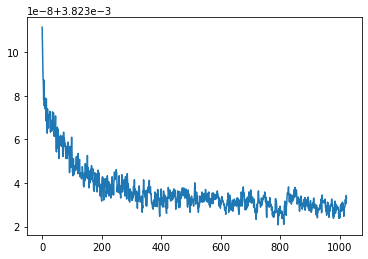

historyRidge.history['loss'][-1]: 0.003823033068329096


In [73]:
(model,modelRidge,lambda_tilda) = train_both_models(lr=lr,
                x_train=x_train,
                y_train=y_train,
                batch_size=min(n_samples, 512),
                epoch_nr=epoch_nr,
                verbose=0,
                validation_data=(x_val, y_val),
                shuffle=True,
                weight_name=weight_name,
                n=n,
                s=s, seed=None, use_final_bias=False, linear_skip=False, din=1, l2reg_factor_affine_weights=2**(-15*0))


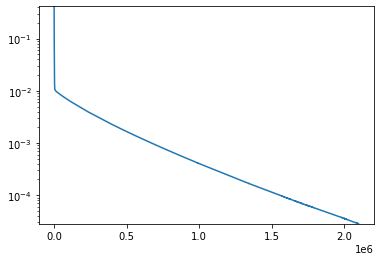

tr_time: 1048576.0 , tr_time_paper: 65536.0
lambda_tilde: 2.775081190439827e-07 , lambda_tilde_paper: 4.4401299047037236e-06 , lambda_tilde equivalent formula: 2.775081190439827e-07 , lambda_tilde_paper equivalent formula: 4.4401299047037236e-06
(16, 1024)
x_train:
(16, 1)
rescale_affine_weights:  1024.0
Ridge regression claculated successfull


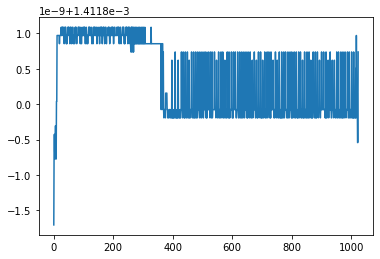

historyRidge.history['loss'][-1]: 0.0014118007384240627


In [83]:
epoch_nr = 2**21 #middle:2**(16) #2**7#2**(12)  # number of epochs
lr = 2**(-1) #middle:2**(-3) #1**(-6)  # learning rate
tr_time = epoch_nr*lr  # training time  (tr_time*n_samples = T_paper)
weight_name = "sinWithAffineWeights"+str(epoch_nr)+'_logT'+str(int(math.log(tr_time, 2)))+'.h5'

(model,modelRidge,lambda_tilda) = train_both_models(lr=lr,
                x_train=x_train,
                y_train=y_train,
                batch_size=min(n_samples, 512),
                epoch_nr=epoch_nr,
                verbose=0,
                validation_data=(x_val, y_val),
                shuffle=True,
                weight_name=weight_name,
                n=n,
                s=s, seed=1, use_final_bias=True, linear_skip=True, din=1, l2reg_factor_affine_weights=2**(-20))


{'model': <keras.engine.functional.Functional object at 0x7efd1b6052a0>, 'modelRidge': <keras.engine.functional.Functional object at 0x7efd38f892d0>, 'radPlot': 1.2, 'x_min': None, 'x_max': None, 'y_min': -1.2, 'y_max': 1.2, 'legend_loc': None, 'frameon': True, 'add_splitting_T': False, 'add_splitting_ridge': True, 'file_name': 'sinWithAffineWeightsMoreEpochswhiteLegend_logT20NoLabel', 'label_T': 'time-T RSN', 'label_ridge': 'ridge RSN', 'label_spline': 'spline', 'label_plus_T': 'time-T RSN+', 'label_minus_T': 'time-T RSN-', 'label_plus_ridge': 'ridge RSN+', 'label_minus_ridge': 'ridge RSN-', 'sign': 'b', 'add_to_plot': False, 'version_without_labels': False, 'legend_alpha': 0.0, 'framealpha': 0.85, 'LegendBoxEdgecolor': 'white'}
g(0)= 0.00015625000000000003
lambda_paper: 1.3875405952199133e-05
60/60 [==============================] - 0s 1ms/step


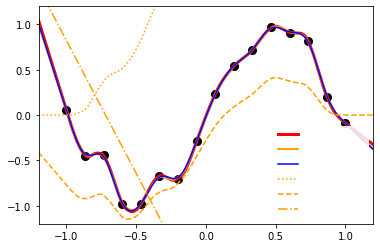

g(0)= 0.00015625000000000003
lambda_paper: 1.3875405952199133e-05
60/60 [==============================] - 0s 1ms/step


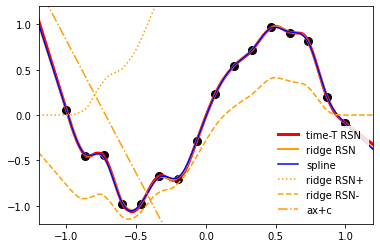

In [88]:
plot_f_advanced(model, modelRidge, radPlot=1.2, add_splitting_T=False,file_name='sinWithAffineWeightsMoreEpochswhiteLegend'+'_logT'+str(int(math.log(tr_time, 2))),legend_alpha=1.0, frameon=True,framealpha=0.85,LegendBoxEdgecolor='white',y_min=-1.2,y_max=1.2)

{'model': <keras.engine.functional.Functional object at 0x7efd1bed3550>, 'modelRidge': <keras.engine.functional.Functional object at 0x7efd1bc37910>, 'radPlot': 1.2, 'x_min': None, 'x_max': None, 'y_min': None, 'y_max': None, 'legend_loc': None, 'frameon': True, 'add_splitting_T': False, 'add_splitting_ridge': True, 'file_name': 'sinWithoutAffineWeightsMoreEpochswhiteLegend_logT18NoLabel', 'label_T': 'time-T RSN', 'label_ridge': 'ridge RSN', 'label_spline': 'spline', 'label_plus_T': 'time-T RSN+', 'label_minus_T': 'time-T RSN-', 'label_plus_ridge': 'ridge RSN+', 'label_minus_ridge': 'ridge RSN-', 'sign': 'b', 'add_to_plot': False, 'version_without_labels': False, 'legend_alpha': 0.0, 'framealpha': 0.85, 'LegendBoxEdgecolor': 'white'}
g(0)= 0.00015625000000000003
lambda_paper: 5.550162380879653e-05
60/60 [==============================] - 0s 1ms/step


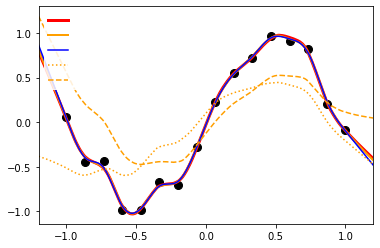

g(0)= 0.00015625000000000003
lambda_paper: 5.550162380879653e-05
60/60 [==============================] - 0s 1ms/step


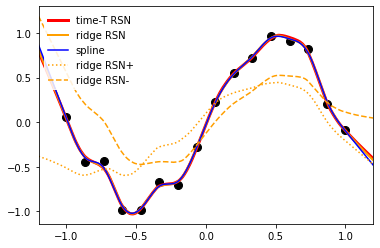

In [76]:
plot_f_advanced(model, modelRidge, radPlot=1.2, add_splitting_T=False,file_name='sinWithoutAffineWeightsMoreEpochswhiteLegend'+'_logT'+str(int(math.log(tr_time, 2))),legend_alpha=1.0, frameon=True,framealpha=0.85,LegendBoxEdgecolor='white')

In [ ]:
(model,modelRidge,lambda_tilda) = train_both_models(lr=lr,
                x_train=x_train,
                y_train=y_train,
                batch_size=min(n_samples, 512),
                epoch_nr=epoch_nr,
                verbose=0,
                validation_data=(x_val, y_val),
                shuffle=True,
                weight_name=weight_name,
                n=n,
                s=s, seed=None, use_final_bias=False, linear_skip=False, din=1, l2reg_factor_affine_weights=2**(-15*0))


{'model': <keras.engine.functional.Functional object at 0x7efcb85f42e0>, 'modelRidge': <keras.engine.functional.Functional object at 0x7efc505e9d50>, 'radPlot': 1.5, 'x_min': None, 'x_max': None, 'y_min': None, 'y_max': None, 'legend_loc': None, 'frameon': True, 'add_splitting_T': False, 'add_splitting_ridge': True, 'file_name': 'sinWithoutAffineWeightsMoreEpochswhiteLegend_logT16NoLabel', 'label_T': 'time-T RSN', 'label_ridge': 'ridge RSN', 'label_spline': 'spline', 'label_plus_T': 'time-T RSN+', 'label_minus_T': 'time-T RSN-', 'label_plus_ridge': 'ridge RSN+', 'label_minus_ridge': 'ridge RSN-', 'sign': 'b', 'add_to_plot': False, 'version_without_labels': False, 'legend_alpha': 0.0, 'framealpha': 0.85, 'LegendBoxEdgecolor': 'white'}
g(0)= 0.00015625000000000003
lambda_paper: 0.00022200649523518613
60/60 [==============================] - 0s 1ms/step


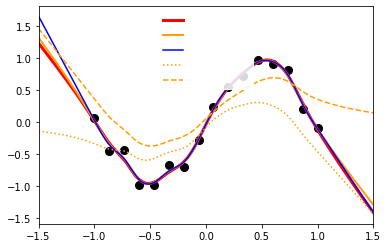

g(0)= 0.00015625000000000003
lambda_paper: 0.00022200649523518613
60/60 [==============================] - 0s 1ms/step


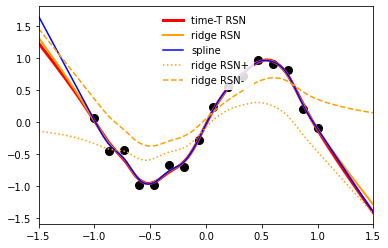

In [71]:
plot_f_advanced(model, modelRidge, radPlot=1.5, add_splitting_T=False,file_name='sinWithoutAffineWeightsMoreEpochswhiteLegend'+'_logT'+str(int(math.log(tr_time, 2))),legend_alpha=1.0, frameon=True,framealpha=0.85,LegendBoxEdgecolor='white')

{'model': <keras.engine.functional.Functional object at 0x7efd394d6ec0>, 'modelRidge': <keras.engine.functional.Functional object at 0x7efcb851fac0>, 'radPlot': 1.5, 'x_min': None, 'x_max': None, 'y_min': None, 'y_max': None, 'legend_loc': None, 'frameon': True, 'add_splitting_T': False, 'add_splitting_ridge': True, 'file_name': 'sinWithoutAffineWeightsMoreEpochswhiteLegend_logT13NoLabel', 'label_T': 'time-T RSN', 'label_ridge': 'ridge RSN', 'label_spline': 'spline', 'label_plus_T': 'time-T RSN+', 'label_minus_T': 'time-T RSN-', 'label_plus_ridge': 'ridge RSN+', 'label_minus_ridge': 'ridge RSN-', 'sign': 'b', 'add_to_plot': False, 'version_without_labels': False, 'legend_alpha': 0.0, 'framealpha': 0.85, 'LegendBoxEdgecolor': 'white'}
g(0)= 0.00015625000000000003
lambda_paper: 0.001776051961881489
60/60 [==============================] - 0s 1ms/step


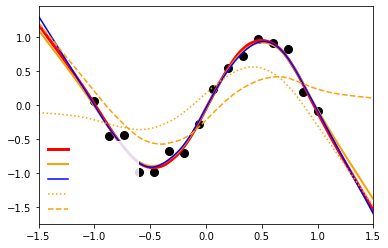

g(0)= 0.00015625000000000003
lambda_paper: 0.001776051961881489
60/60 [==============================] - 0s 1ms/step


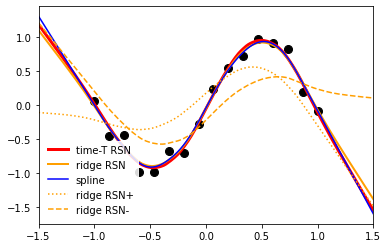

In [68]:
plot_f_advanced(model, modelRidge, radPlot=1.5, add_splitting_T=False,file_name='sinWithoutAffineWeightsMoreEpochswhiteLegend'+'_logT'+str(int(math.log(tr_time, 2))),legend_alpha=1.0, frameon=True,framealpha=0.85,LegendBoxEdgecolor='white')

model.summary()

model.summary

In [43]:
stop

NameError: name 'stop' is not defined

In [ ]:
#stop here

# Old Stuff

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# %%
# import packages, set path and create tf session

import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.initializers import RandomUniform
from keras import regularizers
from keras import optimizers
import keras
import matplotlib.pyplot as plt
import tensorflow
import rpy2.robjects as robjects

project_path = ""

sess = tensorflow.InteractiveSession()
sess.run(tensorflow.global_variables_initializer())


# %%
# define functions

def createModel(n=100, s=0.05, l2reg=0, seed=None):
    # creates an RSN with n hidden nodes with first-layer parameters
    # sampled from Unif[-s, s] and terminal-layer parameters initialized
    # to zero. Ridge regularization on all parameters is controlled by l2reg.

    model = Sequential()
    model.add(Dense(n,
                    activation='relu',
                    input_dim=d,
                    trainable=False,
                    kernel_initializer=RandomUniform(minval=-s,
                                                     maxval=s,
                                                     seed=seed),
                    bias_initializer=RandomUniform(minval=-s,
                                                   maxval=s,
                                                   seed=seed),
                    kernel_regularizer=regularizers.l2(l2reg),
                    bias_regularizer=regularizers.l2(l2reg),
                    name="myHiddenLayer"))
    model.add(Dense(1,
                    activation='linear',
                    kernel_initializer=keras.initializers.Zeros(),
                    bias_initializer=keras.initializers.Zeros(),
                    kernel_regularizer=regularizers.l2(l2reg),
                    bias_regularizer=regularizers.l2(l2reg),
                    name="myOutputLayer"))
 
    return model


def createModelRandomIni(n=100, s=0.05, l2reg=0,
                         seed=None, sSecondLayerRand=None):
    # creates an RSN with n hidden nodes with first-layer parameters
    # sampled from Unif[-s, s] and terminal-layer parameters initialized
    # to samples from Unif[-sSecondLayerRand, sSecondLayerRand].
    # Ridge regularization on all parameters is controlled by l2reg.

    # if no value for sSecondLayerRand is provided, choose Unif[-s, s] 
    # initialization for terminal-layer parameters as well
    if not sSecondLayerRand:
        sSecondLayerRand = s

    model = Sequential()
    model.add(Dense(n,
                    activation='relu',
                    input_dim=d,
                    trainable=False,
                    kernel_initializer=RandomUniform(minval=-s,
                                                     maxval=s,
                                                     seed=seed),
                    bias_initializer=RandomUniform(minval=-s,
                                                   maxval=s,
                                                   seed=seed),
                    kernel_regularizer=regularizers.l2(l2reg),
                    bias_regularizer=regularizers.l2(l2reg),
                    name="myHiddenLayer"))
    model.add(Dense(d,
                    activation='linear',
                    kernel_initializer=RandomUniform(minval=-sSecondLayerRand,
                                                     maxval=sSecondLayerRand,
                                                     seed=seed),
                    bias_initializer=RandomUniform(minval=-sSecondLayerRand,
                                                   maxval=sSecondLayerRand,
                                                   seed=seed),
                    kernel_regularizer=regularizers.l2(l2reg),
                    bias_regularizer=regularizers.l2(l2reg),
                    name="myOutputLayer")) 
    return model


def splineFit(x_train, y_train, lamb):
    # extract R function for cubic smoothing spline and fit it to data w.r.t.
    # the penalty parameter lamb
    # returns the fitted spline

    r_x = robjects.FloatVector(x_train)
    r_y = robjects.FloatVector(y_train)

    r_smooth_spline = robjects.r['smooth.spline'] #extract R function
    kwargs = {"x": r_x, "y": r_y, "lambda": lamb}

    return r_smooth_spline(**kwargs)


def splinePredict(spline, x):
    # evaluate the fitted cubic smoothing spline 'spline' at the data x
    # returns: function evaluations as np.array

    pred = robjects.r['predict'](spline, robjects.FloatVector(x)).rx2('y')
    return np.array(pred)

# %%
# set parameters and create data

np.random.seed(seed=3+2)  # set seed

d = 1  # output dimension
n_samples = 16  # number of samples

# RSN parameter
s = 0.05  # range of random initialization
n = 1024  # number of hidden nodes

# training parameter
epoch_nr = 2**(11)  # number of epochs
lr = 2**(-1)  # learning rate
tr_time = epoch_nr*lr  # training time  (tr_time*n_samples = T_paper)
weight_name = str(epoch_nr)+'_logT'+str(int(math.log(tr_time, 2)))+'.h5'


# training data
x_min = -1
x_max = 1
x_train = np.array(np.linspace(x_min, x_max, n_samples)).reshape(n_samples, d)
x_train = np.sort(x_train, 0)

# xrange for plots
resolution = 1920
x_smooth = np.array(np.linspace(x_min, x_max, resolution)).reshape(resolution, 1)

y_min = -500.6
y_max = 500.6

# training output #HERE YOU CAN CHANGE THE y-DATA BY REPLACING np.sin
y_train = (np.random.normal(scale=1/8,
                            size=n_samples)+np.sin(np.pi*x_train[:, 0]))

# validation data
x_val = ((np.random.rand(256, d)-0.5)*2.0).reshape(256, d)
y_val = np.sin(np.pi*x_val[:, 0])

# plot training (and validation data)
plt.plot(x_train, y_train,'go')
#plt.plot(x_val, y_val,'k.')


# %%
# set up RSN and compile

model = createModelRandomIni(n=n)

model.compile(optimizer=optimizers.SGD(learning_rate=lr),
              loss='MSE',
              metrics=['MSE'])

# (plot untrained network)
#plt.plot(x_smooth,model.predict(x_smooth))
#plt.plot(x_train, y_train, 'go')

# %%
# train RSN 
history = model.fit(x_train,
                    y_train,
                    batch_size=min(n_samples, 512),
                    epochs=epoch_nr,
                    verbose=0,
                    validation_data=(x_val, y_val),
                    shuffle=True)
# save weights in cwd
model.save_weights('RSN'+weight_name)
#w = model.get_weights() #can improof speed

# (visualize training & validation loss)
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])

# %%
# set up ridge regularized RSN using eq. (6) in the paper for lambda_tilda

sSVD = n_samples/(2*tr_time) #(singular value of XTX) = (singular value of X)^2
lambda_tilda = sSVD/(np.exp(2*sSVD*tr_time/n_samples)-1)/n_samples 

modelRidge = createModel(n=n, l2reg=lambda_tilda)
#modelRidge.set_weights(w) #can improof speed

modelRidge.compile(optimizer=optimizers.Adam(learning_rate=2**(-11)),
             loss='MSE',
             metrics=['MSE'])

# %%
# train ridge regularized RSN
historyRidge = modelRidge.fit(x_train,
                              y_train,
                              batch_size=min(n_samples, 512),
                              epochs=2**15,
                              verbose=0,
                              validation_data=(x_train, y_train),
                              shuffle=True)

# save weights in cwd
model.save_weights('RidgeRSN'+weight_name)

# (visualize training loss)
#plt.plot(historyRidge.history['loss'])

# %%
# fit spline regression with g(0) and regularizing parameter lambda (lamb)
# as in the paper including an adjustment for the scaling of lamb
# (see https://stats.stackexchange.com/a/430482/261315)


g_Zero = s**2/8 
print('g(0)=', g_Zero)
lamb = float((n_samples*lambda_tilda/g_Zero/n)/(max(x_train)-min(x_train))**3) 

spline = splineFit(x_train, y_train, lamb)


# %%
# visualize result

radPlot = 1
xPlot = np.linspace(-radPlot, radPlot, 1920)
ySpline = splinePredict(spline, xPlot)
yminPlot = min(np.min(model.predict(xPlot)),
               np.min(modelRidge.predict(xPlot)))-0.05
ymaxPlot = max(np.max(model.predict(xPlot)),
               np.max(modelRidge.predict(xPlot)))+0.05
  
plt.plot(x_train, y_train, 'ko', markersize=8) 
plt.plot(xPlot, model.predict(xPlot), 'r-', linewidth=3, label='time-T RSN')
plt.plot(xPlot, modelRidge.predict(xPlot), '-', linewidth=3,
         color=(1, 5/8, 0.0), label='ridge RSN')
plt.plot(xPlot, ySpline, 'b-', linewidth=2, label='spline')
  
plt.ylim(-1.125, 1.125)
plt.xlim(-radPlot, radPlot)
 
plt.legend(loc='upper left', frameon=False)  

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# %%
# import packages, set path and create tf session

import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.initializers import RandomUniform
from keras import regularizers
from keras import optimizers
import keras
import matplotlib.pyplot as plt
import tensorflow
import rpy2.robjects as robjects

project_path = ""

sess = tensorflow.InteractiveSession()
sess.run(tensorflow.global_variables_initializer())


# %%
# define functions

def createModel(n=100, s=0.05, l2reg=0, seed=None):
    # creates an RSN with n hidden nodes with first-layer parameters
    # sampled from Unif[-s, s] and terminal-layer parameters initialized
    # to zero. Ridge regularization on all parameters is controlled by l2reg.

    model = Sequential()
    model.add(Dense(n,
                    activation='relu',
                    input_dim=d,
                    trainable=False,
                    kernel_initializer=RandomUniform(minval=-s,
                                                     maxval=s,
                                                     seed=seed),
                    bias_initializer=RandomUniform(minval=-s,
                                                   maxval=s,
                                                   seed=seed),
                    kernel_regularizer=regularizers.l2(l2reg),
                    bias_regularizer=regularizers.l2(l2reg),
                    name="myHiddenLayer"))
    model.add(Dense(1,
                    activation='linear',
                    kernel_initializer=keras.initializers.Zeros(),
                    bias_initializer=keras.initializers.Zeros(),
                    kernel_regularizer=regularizers.l2(l2reg),
                    bias_regularizer=regularizers.l2(l2reg),
                    name="myOutputLayer"))
 
    return model


def createModelRandomIni(n=100, s=0.05, l2reg=0,
                         seed=None, sSecondLayerRand=None):
    # creates an RSN with n hidden nodes with first-layer parameters
    # sampled from Unif[-s, s] and terminal-layer parameters initialized
    # to samples from Unif[-sSecondLayerRand, sSecondLayerRand].
    # Ridge regularization on all parameters is controlled by l2reg.

    # if no value for sSecondLayerRand is provided, choose Unif[-s, s] 
    # initialization for terminal-layer parameters as well
    if not sSecondLayerRand:
        sSecondLayerRand = s

    model = Sequential()
    model.add(Dense(n,
                    activation='relu',
                    input_dim=d,
                    trainable=False,
                    kernel_initializer=RandomUniform(minval=-s,
                                                     maxval=s,
                                                     seed=seed),
                    bias_initializer=RandomUniform(minval=-s,
                                                   maxval=s,
                                                   seed=seed),
                    kernel_regularizer=regularizers.l2(l2reg),
                    bias_regularizer=regularizers.l2(l2reg),
                    name="myHiddenLayer"))
    model.add(Dense(d,
                    activation='linear',
                    kernel_initializer=RandomUniform(minval=-sSecondLayerRand,
                                                     maxval=sSecondLayerRand,
                                                     seed=seed),
                    bias_initializer=RandomUniform(minval=-sSecondLayerRand,
                                                   maxval=sSecondLayerRand,
                                                   seed=seed),
                    kernel_regularizer=regularizers.l2(l2reg),
                    bias_regularizer=regularizers.l2(l2reg),
                    name="myOutputLayer")) 
    return model


def splineFit(x_train, y_train, lamb):
    # extract R function for cubic smoothing spline and fit it to data w.r.t.
    # the penalty parameter lamb
    # returns the fitted spline

    r_x = robjects.FloatVector(x_train)
    r_y = robjects.FloatVector(y_train)

    r_smooth_spline = robjects.r['smooth.spline'] # extract R function
    kwargs = {"x": r_x, "y": r_y, "lambda": lamb}

    return r_smooth_spline(**kwargs)


def splinePredict(spline, x):
    # evaluate the fitted cubic smoothing spline 'spline' at the data x
    # returns: function evaluations as np.array

    pred = robjects.r['predict'](spline, robjects.FloatVector(x)).rx2('y')
    return np.array(pred)

# %%
# set parameters and create data

np.random.seed(seed=3+2)  # set seed

d = 1  # output dimension
n_samples = 16  # number of samples

# RSN parameter
s = 0.05  # range of random initialization
n = 1024  # number of hidden nodes

# training parameter
epoch_nr = 2**(11)  # number of epochs
lr = 2**(-1)  # learning rate
tr_time = epoch_nr*lr  # training time  (tr_time*n_samples = T_paper)
weight_name = str(epoch_nr)+'_logT'+str(int(math.log(tr_time, 2)))+'.h5'


# training data
x_min = -1
x_max = 1
x_train = np.array(np.linspace(x_min, x_max, n_samples)).reshape(n_samples, d)
x_train = np.sort(x_train, 0)

# xrange for plots
resolution = 1920
x_smooth = np.array(np.linspace(x_min, x_max, resolution)).reshape(resolution, 1)

y_min = -500.6
y_max = 500.6

# training output  # HERE YOU CAN CHANGE THE y-DATA BY REPLACING np.sin
y_train = (np.random.normal(scale=1/8,
                            size=n_samples)+np.sin(np.pi*x_train[:, 0]))

# validation data
x_val = ((np.random.rand(256, d)-0.5)*2.0).reshape(256, d)
y_val = np.sin(np.pi*x_val[:, 0])

# plot training (and validation data)
plt.plot(x_train, y_train,'go')
# plt.plot(x_val, y_val,'k.')


# %%
# set up RSN and compile

model = createModelRandomIni(n=n)

model.compile(optimizer=optimizers.SGD(learning_rate=lr),
              loss='MSE',
              metrics=['MSE'])

# (plot untrained network)
# plt.plot(x_smooth,model.predict(x_smooth))
# plt.plot(x_train, y_train, 'go')

# %%
# train RSN 
history = model.fit(x_train,
                    y_train,
                    batch_size=min(n_samples, 512),
                    epochs=epoch_nr,
                    verbose=0,
                    validation_data=(x_val, y_val),
                    shuffle=True)
# save weights in cwd
model.save_weights('RSN'+weight_name)
# w = model.get_weights() # can improve speed

# (visualize training & validation loss)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

# %%
# set up ridge regularized RSN using eq. (6) in the paper for lambda_tilda

sSVD = n_samples/(2*tr_time) #(singular value of XTX) = (singular value of X)^2
lambda_tilda = sSVD/(np.exp(2*sSVD*tr_time/n_samples)-1)/n_samples 

modelRidge = createModel(n=n, l2reg=lambda_tilda)
# modelRidge.set_weights(w) # can improve speed

modelRidge.compile(optimizer=optimizers.Adam(learning_rate=2**(-11)),
             loss='MSE',
             metrics=['MSE'])

# %%
# train ridge regularized RSN
historyRidge = modelRidge.fit(x_train,
                              y_train,
                              batch_size=min(n_samples, 512),
                              epochs=2**15,
                              verbose=0,
                              validation_data=(x_train, y_train),
                              shuffle=True)

# save weights in cwd
model.save_weights('RidgeRSN'+weight_name)

# (visualize training loss)
# plt.plot(historyRidge.history['loss'])

# %%
# fit spline regression with g(0) and regularizing parameter lambda (lamb)
# as in the paper including an adjustment for the scaling of lamb
# (see https://stats.stackexchange.com/a/430482/261315)


g_Zero = s**2/8 
print('g(0)=', g_Zero)
lamb = float((n_samples*lambda_tilda/g_Zero/n)/(max(x_train)-min(x_train))**3) 

spline = splineFit(x_train, y_train, lamb)


# %%
# visualize result

radPlot = 1
xPlot = np.linspace(-radPlot, radPlot, resolution)
ySpline = splinePredict(spline, xPlot)
yminPlot = min(np.min(model.predict(xPlot)),
               np.min(modelRidge.predict(xPlot)))-0.05
ymaxPlot = max(np.max(model.predict(xPlot)),
               np.max(modelRidge.predict(xPlot)))+0.05
  
plt.plot(x_train, y_train, 'ko', markersize=8) 
plt.plot(xPlot, model.predict(xPlot), 'r-', linewidth=3, label='time-T RSN')
plt.plot(xPlot, modelRidge.predict(xPlot), '-', linewidth=3,
         color=(1, 5/8, 0.0), label='ridge RSN')
plt.plot(xPlot, ySpline, 'b-', linewidth=2, label='spline')
  
plt.ylim(-1.125, 1.125)
plt.xlim(-radPlot, radPlot)
 
plt.legend(loc='upper left', frameon=False)  